# Cross-matching entre catalogues X et optique

"Entraînement" au cross-matching avec les catalogues erosita et sdss_wen → envoyé par Reza dans un mail du 14/02/2025 à 12h26

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
import math
import scipy
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table
from astropy.cosmology import Planck13
import pickle
import os

In [65]:
from gem_astmatch_modified import match_celestial_objects_list_deg,match_celestial_objects,create_skycoord_from_fits,do_celest_match_fits   

# Import catalogues

Fonction pour passer de .fit à un dataframe (REMARQUE : Le programme ne semble pas fonctionner pour certains fits binary → dans le doute télécharger des fits ascii) : 

In [66]:
#Description des tables :
# catass -  est la table eRosita de départ, enrichie avec des informations d'association avec SDSS-Wen 
# dtass - contient juste l'information d'association, pour l'objet la plus proche (en angle) 
# dtassall - contient l'information d'association , uniquement pour les objets X ayant été associés à un objet optique, et tous les objets qui passent le critère d'association (angulaire et en redshift) 

'''
#Ne fonctionnait car le cgicher étaut un fits binary
def fits_to_dataframe_catass(fits_file):
    with fits.open(fits_file) as hdul:
        catass = hdul[1].data 
        catass_df = pd.DataFrame(catass)

        dtass_binary = hdul[2].data 
        dtass = Table(dtass_binary) 
        dtass.write('dtass.fits', overwrite=True, format='ascii') 
        dtass_df = pd.DataFrame(dtass)

        dtassall = hdul[3].data 
        dtassall_df = pd.DataFrame(dtassall)
    return catass_df, dtass_df, dtassall_df'''

# Transforme certaines extensions d'un fichier FITS en un fichier FITS ASCII
def fits_binary_to_fits_ascii_list(fits_file, liste_indexes, name_list):  # liste_indexes indique les extensions du fits à lire ; name_list correspond aux noms des fichiers de sortie
    for x, x_name in zip(liste_indexes, name_list):  # Use zip to iterate over both lists simultaneously
        with fits.open(fits_file) as hdul:
            data = hdul[x].data
            data_table = Table(data)  # Convertit le tableau binaire en un tableau astropy
            data_table.write(x_name, overwrite=True, format='ascii')  # Écrit le tableau dans un fichier FITS ASCII

#Transforme un FITS ascii en un DataFrame pandas
def ascii_to_dataframe(ascii_file, delimiter=' '):
    data_df = pd.read_csv(ascii_file, delimiter=delimiter)
    return data_df

# Transfome la première extension d'un fichier FITS en un DataFrame pandas
def fits_to_dataframe(fits_file):
    with fits.open(fits_file) as hdul:
        data = hdul[1].data 
        data_df = pd.DataFrame(data)
    return data_df



# Transforme certaines extensions d'un fichier FITS en un DataFrame pandas(→ pour que ça fonctionne, il faut un fits ascii et pas un fits binaire)
def fits_to_dataframe_list(fits_file, liste_indexes):  # liste_indexes indique les extensions du fits à lire
    df_list = []  # Initialize the list outside the loop
    with fits.open(fits_file) as hdul:
        for x in liste_indexes:
            data = hdul[x].data  # Select the data in the xth extension
            df_list.append(pd.DataFrame(data))
            print(df_list)
    return df_list  # Return the entire list of DataFrames

#def fits_binary_to_fits_ascii(fits_file):

On précise le chemin menant à chacun des catalogues pour ensuite les importer

In [67]:
path_X = 'clxC.fits' #la première table est la table eRosita de départ, enrichie avec des informations d'association avec SDSS-Wen
name_X = 'eROSITA_BULBUL_2024'

path_opt = '../DESI_eRass/DESI_Legacy_Wen_2024.fit'
name_opt = 'Wen_2024_DESI_Legacy'

In [68]:
'''clx_catass_df = fits_to_dataframe(path_X) # !!! clx_dtass_df, clx_dtassall_df → problème de BigEndian → sans doute que les fits sont binary et non pas ascii !!!
fits_binary_to_fits_ascii_list(path_X,[1,2,3],['clxC_catass.ascii','clxC_dtass.ascii','clxC_dtassall.ascii']) #Change les fichiers dans le dossier !''' 

"clx_catass_df = fits_to_dataframe(path_X) # !!! clx_dtass_df, clx_dtassall_df → problème de BigEndian → sans doute que les fits sont binary et non pas ascii !!!\nfits_binary_to_fits_ascii_list(path_X,[1,2,3],['clxC_catass.ascii','clxC_dtass.ascii','clxC_dtassall.ascii']) #Change les fichiers dans le dossier !"

In [69]:
if path_X == 'clxB.fits':
    clx_catass_df = ascii_to_dataframe('clxB_catass.ascii')
    clx_dtass_df = ascii_to_dataframe('clxB_dtass.ascii') 
    clx_dtassall_df = ascii_to_dataframe('clxB_dtassall.ascii')  

elif path_X == 'clxC.fits':
    clx_catass_df = ascii_to_dataframe('clxC_catass.ascii')
    clx_dtass_df = ascii_to_dataframe('clxC_dtass.ascii') 
    clx_dtassall_df = ascii_to_dataframe('clxC_dtassall.ascii')

In [70]:
# On veut récupérer la table Erosita de départ que Reza a utilisé → Ezra Bulbul 2024
columns_to_exclude = ['idm', 'asscnt','idass','dstass','delz','maxassdist','zph','rmag','r200','N200']
table_X = clx_catass_df.drop(columns=columns_to_exclude) # Pour l'instant, table eRosita
table_X


_RAJ2000   _DEJ2000                     Name     RAJ2000    DEJ2000  \
0        0.021730 -38.624903  1eRASS J000005.2-383729    0.021730 -38.624903   
1        0.089191 -82.831715  1eRASS J000021.4-824954    0.089191 -82.831715   
2        0.129422 -50.151013  1eRASS J000031.0-500903    0.129422 -50.151013   
3        0.132712 -63.025286  1eRASS J000031.8-630131    0.132712 -63.025286   
4        0.189080 -46.394874  1eRASS J000045.3-462341    0.189080 -46.394874   
...           ...        ...                      ...         ...        ...   
12241  359.741833 -60.612333  1eRASS J235858.0-603644  359.741833 -60.612333   
12242  359.799123 -55.296727  1eRASS J235911.7-551748  359.799123 -55.296727   
12243  359.864701 -34.306012  1eRASS J235927.5-341821  359.864701 -34.306012   
12244  359.980381 -44.205215  1eRASS J235955.2-441218  359.980381 -44.205215   
12245  359.983837 -39.473995  1eRASS J235956.1-392826  359.983837 -39.473995   

              Exp   zBest  e_zBest        zType  pcont  ...  CTS300kpc  \
0       94.800003  0.3153   0.0079      photo_z  0.006  ...       33.4   
1      184.199997  0.0891   0.0002    cg_spec_z  0.000  ...      128.8   
2      117.300003  0.0681   0.0002    cg_spec_z  0.218  ...       29.9   
3      139.600006  0.2448   0.0058      photo_z  0.005  ...       24.3   
4      109.500000  0.0925   0.0004    cg_spec_z  0.715  ...       20.0   
...           ...     ...      ...          ...    ...  ...        ...   
12241  142.500000  0.1052   0.0064      photo_z  0.000  ...      204.7   
12242  130.800003  0.2137   0.0063      photo_z  0.506  ...       15.3   
12243   87.500000  0.1138   0.0004  spec_z_boot  0.003  ...       42.6   
12244   98.099998  0.5797   0.0117      photo_z  0.982  ...       12.3   
12245   93.000000  0.1024   0.0004    cg_spec_z  0.000  ...      110.6   

       CTS500     F500     L500    KT     Mgas500   YX500       M500  Fgas500  \
0        48.2   47.110  140.172  1.90  279.160004  553.19  36.070000    0.075   
1       189.5   98.355   24.747   NaN  111.919998    0.00  16.990000    0.065   
2        30.3   23.991    2.862  1.79    1.920000    9.34   3.630000    0.009   
3        49.6   33.228   57.877   NaN  171.949997    0.00  22.040001    0.076   
4        20.8   16.818    3.996  0.96    6.400000   11.17   3.780000    0.019   
...       ...      ...      ...   ...         ...     ...        ...      ...   
12241   506.8  337.065   97.721   NaN  358.950012    0.00  38.669998    0.093   
12242    15.8   11.402   15.028   NaN    5.590000    0.00   8.150000    0.008   
12243    62.5   62.778   22.350   NaN   81.230003    0.00  14.110000    0.054   
12244    13.4   12.342  165.113   NaN   41.310001    0.00  25.920000    0.020   
12245   188.0  192.414   52.418  4.18  192.529999  793.02  27.010000    0.071   

       R500  
0       971  
1       819  
2       493  
3       846  
4       495  
...     ...  
12241  1071  
12242   614  
12243   763  
12244   785  
12245   951  

[12246 rows x 22 columns]

REMARQUE : M500 dans la table_X est en $10^{13} M_{SUN}$.

In [71]:
table_optique = fits_to_dataframe(path_opt)


REMARQUE POUR DESI Legacy Imaging Surveys WEN 2024 : M500 est en $10^{14} M_{SUN}$, on convertit donc cette colonne en $10^{13} M_{SUN}$,

In [72]:
# SEULEMENT SI WEN_2024 DESI LEGACY 

M500_opt_13 = table_optique['M500']*10
table_optique['M500'] = M500_opt_13


In [73]:
# On calcule les coordonnées galactiques
'''# objets X 
raj2000_x_list = table_X['RAJ2000'].tolist()
dej2000_x_list = table_X['DEJ2000'].tolist()
j2000_coords_x = SkyCoord(raj2000_x_list, dej2000_x_list, unit=(u.degree, u.degree), frame='icrs')
galactic_coords_x = j2000_coords_x.galactic # conversion J2000 -> galactique

# objets optiques 
raj2000_opt_list = table_optique['RAJ2000'].tolist()
dej2000_opt_list = table_optique['DEJ2000'].tolist()
j2000_coords_opt = SkyCoord(raj2000_opt_list, dej2000_opt_list, unit=(u.degree, u.degree), frame='icrs')
galactic_coords_opt = j2000_coords_opt.galactic # conversion J2000 -> galactique

#On les exporte dans le dossier ../DESI_eRass/'''

output_folder = "../DESI_eRass/"  

'''
# Save 'galactic_coords_x'
with open(os.path.join(output_folder, 'galactic_coords_x.pkl'), 'wb') as file:
    pickle.dump(galactic_coords_x, file)

# Save 'galactic_coords_opt'
with open(os.path.join(output_folder, 'galactic_coords_opt.pkl'), 'wb') as file:
    pickle.dump(galactic_coords_opt, file)'''

"\n# Save 'galactic_coords_x'\nwith open(os.path.join(output_folder, 'galactic_coords_x.pkl'), 'wb') as file:\n    pickle.dump(galactic_coords_x, file)\n\n# Save 'galactic_coords_opt'\nwith open(os.path.join(output_folder, 'galactic_coords_opt.pkl'), 'wb') as file:\n    pickle.dump(galactic_coords_opt, file)"

In [74]:
# On récupère les coordonnées galactiques et on les ajoute aux tables

with open(os.path.join(output_folder, 'galactic_coords_x.pkl'), 'rb') as file:
    galactic_coords_x = pickle.load(file)
with open(os.path.join(output_folder, 'galactic_coords_opt.pkl'), 'rb') as file:
    galactic_coords_opt = pickle.load(file)


table_optique['glon'] = galactic_coords_opt.l.deg ; table_optique['glat'] = galactic_coords_opt.b.deg
table_optique = table_optique[['glat'] + [col for col in table_optique.columns if col != 'glat']]
table_optique = table_optique[['glon'] + [col for col in table_optique.columns if col != 'glon']]

table_X['glon'] = galactic_coords_x.l.deg ; table_X['glat'] = galactic_coords_x.b.deg
table_X = table_X[['glat'] + [col for col in table_X.columns if col != 'glat']]
table_X = table_X[['glon'] + [col for col in table_X.columns if col != 'glon']]

In [75]:
table_X

glon       glat    _RAJ2000   _DEJ2000                     Name  \
0      342.749448 -74.271284    0.021730 -38.624903  1eRASS J000005.2-383729   
1      304.840936 -34.106231    0.089191 -82.831715  1eRASS J000021.4-824954   
2      322.452378 -65.003242    0.129422 -50.151013  1eRASS J000031.0-500903   
3      312.522364 -53.144800    0.132712 -63.025286  1eRASS J000031.8-630131   
4      327.067389 -68.286560    0.189080 -46.394874  1eRASS J000045.3-462341   
...           ...        ...         ...        ...                      ...   
12241  314.228009 -55.350263  359.741833 -60.612333  1eRASS J235858.0-603644   
12242  317.972769 -60.279763  359.799123 -55.296727  1eRASS J235911.7-551748   
12243  357.004161 -76.739220  359.864701 -34.306012  1eRASS J235927.5-341821   
12244  330.823690 -70.028243  359.980381 -44.205215  1eRASS J235955.2-441218   
12245  340.618742 -73.658436  359.983837 -39.473995  1eRASS J235956.1-392826   

          RAJ2000    DEJ2000         Exp   zBest  e_zBest  ... CTS300kpc  \
0        0.021730 -38.624903   94.800003  0.3153   0.0079  ...      33.4   
1        0.089191 -82.831715  184.199997  0.0891   0.0002  ...     128.8   
2        0.129422 -50.151013  117.300003  0.0681   0.0002  ...      29.9   
3        0.132712 -63.025286  139.600006  0.2448   0.0058  ...      24.3   
4        0.189080 -46.394874  109.500000  0.0925   0.0004  ...      20.0   
...           ...        ...         ...     ...      ...  ...       ...   
12241  359.741833 -60.612333  142.500000  0.1052   0.0064  ...     204.7   
12242  359.799123 -55.296727  130.800003  0.2137   0.0063  ...      15.3   
12243  359.864701 -34.306012   87.500000  0.1138   0.0004  ...      42.6   
12244  359.980381 -44.205215   98.099998  0.5797   0.0117  ...      12.3   
12245  359.983837 -39.473995   93.000000  0.1024   0.0004  ...     110.6   

       CTS500     F500     L500    KT     Mgas500   YX500       M500  Fgas500  \
0        48.2   47.110  140.172  1.90  279.160004  553.19  36.070000    0.075   
1       189.5   98.355   24.747   NaN  111.919998    0.00  16.990000    0.065   
2        30.3   23.991    2.862  1.79    1.920000    9.34   3.630000    0.009   
3        49.6   33.228   57.877   NaN  171.949997    0.00  22.040001    0.076   
4        20.8   16.818    3.996  0.96    6.400000   11.17   3.780000    0.019   
...       ...      ...      ...   ...         ...     ...        ...      ...   
12241   506.8  337.065   97.721   NaN  358.950012    0.00  38.669998    0.093   
12242    15.8   11.402   15.028   NaN    5.590000    0.00   8.150000    0.008   
12243    62.5   62.778   22.350   NaN   81.230003    0.00  14.110000    0.054   
12244    13.4   12.342  165.113   NaN   41.310001    0.00  25.920000    0.020   
12245   188.0  192.414   52.418  4.18  192.529999  793.02  27.010000    0.071   

       R500  
0       971  
1       819  
2       493  
3       846  
4       495  
...     ...  
12241  1071  
12242   614  
12243   763  
12244   785  
12245   951  

[12246 rows x 24 columns]

In [76]:
table_optique

glon       glat   _RAJ2000  _DEJ2000       ID n_Name  \
0        346.037516 -75.021144    0.00046 -37.47628        1          
1        316.752759 -59.138458    0.00135 -56.58835        2    WH-   
2        340.962781 -73.774528    0.00172 -39.32369        3          
3         98.087140 -58.049446    0.00201   2.31980        4          
4        315.038146 -56.890161    0.00260 -59.01297        5    WH-   
...             ...        ...        ...       ...      ...    ...   
1581174   99.846285 -55.556496  359.99667   4.99211  1581175    WH-   
1581175  107.386200 -39.528434  359.99680  21.78514  1581176          
1581176  102.648089 -50.784985  359.99817  10.04951  1581177          
1581177   90.146970 -65.886375  359.99847  -6.34469  1581178    WH-   
1581178  101.410122 -53.037823  359.99902   7.67085  1581179          

                     Name    RAJ2000   DEJ2000     zCl  ...  logMs   r500  \
0        J000000.1-372835    0.00046 -37.47628  0.1364  ...  11.49  0.766   
1        J000000.3-563518    0.00135 -56.58835  0.1957  ...  11.70  0.625   
2        J000000.4-391925    0.00172 -39.32369  0.3580  ...  11.41  0.526   
3        J000000.5+021911    0.00201   2.31980  0.4282  ...  11.55  0.612   
4        J000000.6-590047    0.00260 -59.01297  0.1380  ...  11.69  0.606   
...                   ...        ...       ...     ...  ...    ...    ...   
1581174  J235959.2+045932  359.99667   4.99211  0.5948  ...  11.37  0.420   
1581175  J235959.2+214707  359.99680  21.78514  0.4050  ...  11.78  0.658   
1581176  J235959.6+100258  359.99817  10.04951  0.7919  ...  11.88  0.621   
1581177  J235959.6-062041  359.99847  -6.34469  1.0333  ...  11.18  0.439   
1581178  J235959.8+074015  359.99902   7.67085  0.6633  ...  11.27  0.542   

         lam500  M500  Ngal  Gamma  e_Gamma  imag_        Cat    recno  
0         25.79  11.7    14    0.0      0.0      1  WHY18            1  
1         23.24  10.6     7    0.0      0.0      1                   2  
2         15.90   7.3     7    0.0      0.0      1  Y21              3  
3         23.40  10.7    13    0.0      0.0      1  redMaPPer        4  
4         15.71   7.3     7    0.0      0.0      1                   5  
...         ...   ...   ...    ...      ...    ...        ...      ...  
1581174   10.99   5.1     6    0.0      0.0      2             1581175  
1581175   31.73  14.3     9    0.0      0.0      2  WHL        1581176  
1581176   33.23  15.0     8    0.0      0.0      2  CFSFDP     1581177  
1581177   13.12   6.1     6    0.0      0.0      2             1581178  
1581178   14.02   6.5     9    0.0      0.0      2  Y21        1581179  

[1581179 rows x 23 columns]

# Applications sur les tables

## Détermination tolérance angulaire en fonction du redshift (inspiré du code SOPHYA de Reza)

In [77]:
'''tolerance_ang = 30 # tolerance in arcseconds → 30 is approximately the tolerance of eROSITA instrument (we take taht into account because the X-instrument is less precise than the optical one)
#!!! → TO DO : Faire évoluer la tolérance angulaire en foncntion de z (z ↑ => tolerance_ang ↓) : le faire par step de z : s'inspier du code de Reza (noms variables inspirés de )
delta_z = 0.15 # Seuil de différence de redshift (idem que dans le code de Reza → choix arbitraire ?)
'''

"tolerance_ang = 30 # tolerance in arcseconds → 30 is approximately the tolerance of eROSITA instrument (we take taht into account because the X-instrument is less precise than the optical one)\n#!!! → TO DO : Faire évoluer la tolérance angulaire en foncntion de z (z ↑ => tolerance_ang ↓) : le faire par step de z : s'inspier du code de Reza (noms variables inspirés de )\ndelta_z = 0.15 # Seuil de différence de redshift (idem que dans le code de Reza → choix arbitraire ?)\n"

In [78]:
#Paramètres asssociation

skyresol_deg = 5 # découpage du ciel en degrés, pour éviter de comparer un objet à tout les autres dans le ciel, mais seulement à ceux dans la même zone (TO DO : penser à implémenter cet aspect concrètement) 
tol_ang_fixe_arcmin = 15.0 # tolérance angulaire fixe en arcminutes → UTILITé ?
min_tol_ang_arcmin = 5.0 # tolerance angulaire plancher en arcminutes (CHOIX ?)
rayon_cluster_MPC = 1 # rayon du cluster (en MPC) → influence le calcule de la tolérance angulaire en fonction du redshift
delta_z = 0.15 # "largeur" du palier de redshift
cosmo = Planck13 # modèle cosmo utilisé : FlatLambdaCDM(name='Planck13', H0=<Quantity 67.77 km / (Mpc s)>, Om0=0.30712, Tcmb0=<Quantity 2.7255 K>, Neff=3.046, m_nu=<Quantity [0.  , 0.  , 0.06] eV>, Ob0=0.048252)


In [79]:
def find_tol_ang_wrt_z(cosmo,z,rayon_cluster_MPC,min_tol_ang_arcmin,skyresol_deg):
    
    tol_ang_variable = rayon_cluster_MPC/cosmo.angular_diameter_distance(z).value # cosmo.luminosity_distance est en MPC donc tol_ang_variable est en radian
    tol_ang = math.radians((min_tol_ang_arcmin/60)) + tol_ang_variable   # Sûr ???

    skyresol_rad = math.radians(skyresol_deg)

    if tol_ang > skyresol_rad:
        tol_ang = skyresol_rad

    tol_ang = math.degrees(tol_ang) *3600 # Convertit en secondes d'arc
    return tol_ang 

In [80]:
find_tol_ang_wrt_z(cosmo,0.2,rayon_cluster_MPC,min_tol_ang_arcmin,skyresol_deg) # 0.3 est un exemple de redshift (à changer) → renvoie la tolérance angulaire en arcminutes (environ 5.0 arcminutes)

593.7813118212254

In [81]:
find_tol_ang_wrt_z(cosmo,0.3,rayon_cluster_MPC,min_tol_ang_arcmin,skyresol_deg)

517.7584450752764

In [82]:
find_tol_ang_wrt_z(cosmo,0.5,rayon_cluster_MPC,min_tol_ang_arcmin,skyresol_deg)

459.07681676402274

## Association X → optique

In [83]:
# Détermination du nombre de bins de redshift
nb_bin_z_X = round(table_X['zBest'].max()/delta_z,0) ; nb_bin_z_opt = round(table_optique['zCl'].max()/delta_z,0)
nb_bin_z = int(max(nb_bin_z_X, nb_bin_z_opt))
print(f" On va considérer {nb_bin_z} bins de redshift ({delta_z} de large)")

 On va considérer 12 bins de redshift (0.15 de large)


In [84]:
tol_ang_list = [] # On va y placer les tolérances angulaires pour chaque bin de redshift : on prend à chaque fois la valeur maximale du bin de redshift afin d'obtenir la tolérance angulaire la plus contraignante
for i in range(nb_bin_z):
    tol_ang_current = find_tol_ang_wrt_z(cosmo,(i+1)*delta_z,rayon_cluster_MPC,min_tol_ang_arcmin,skyresol_deg)
    tol_ang_list.append(tol_ang_current)
print(f"tol_ang_list : {tol_ang_list}")

tol_ang_list : [670.6665390875297, 517.7584450752764, 468.5552666290355, 445.31787936231916, 432.483176011074, 424.8550346768297, 420.2020766350911, 417.4063374621939, 415.845636939462, 415.1462040492477, 415.07004294083447, 415.45850634100896]


In [85]:
# On découpe les tables en fonction des bins de redshift
table_X_list_bins = []
table_optique_list_bins = [] 

def cut_table_bins_z(table,name_z,nb_bins):
    table_bins_list = []
    for i in range(nb_bins):
        z_min = i*delta_z
        z_max = (i+1)*delta_z
        table_bins = table[(table[name_z] >= z_min) & (table[name_z] <= z_max)]
        table_bins_list.append(table_bins)
    return table_bins_list 

table_X_list_bins = cut_table_bins_z(table_X,'zBest',nb_bin_z) # On découpe la table X en fonction des bins de redshift
#table_optique_list_bins = cut_table_bins_z(table_optique,'zCl',nb_bin_z) # idem mais pour la table optique


In [86]:
# On commence par créer des listes de coordonnées (RAJ2000,DEJ2000) en récupérant les colonnes correspondantes sur les tables

liste_indexes_X = [] # listes des indexes dans cahque bin, pour pouvoir réaliser l'association par la suite (en effet, le découpage en bin de redshift a mélangé les indices dans table_X_list_bins)
liste_coords_X = [] # Liste de coordonnées (RAJ2000,DEJ2000) pour chaque bin de redshift
for x in table_X_list_bins:
    liste_indexes_X_bin = []
    liste_coords_X_bin = []
    for index,row in x.iterrows():
        liste_indexes_X_bin.append(index) ; liste_coords_X_bin.append((row['RAJ2000'],row['DEJ2000']))
    liste_indexes_X.append(liste_indexes_X_bin) ; liste_coords_X.append(liste_coords_X_bin)

liste_coords_optique = []
for i in range(len(table_optique)):
    coord = (table_optique['RAJ2000'][i],table_optique['DEJ2000'][i])
    liste_coords_optique.append(coord)


In [87]:
# A LANCER UNIQUEMENT POUR UN NOUVEAU SET DE PARAMETRES, dans ce cas mettre la variable RUN à True :
RUN = True

# TO DO ; trouver un moyen d'accélérer le calcul ! (voir cross_matching_X_optique _tentative_accel_calcul.ipynb)

folder = '../DESI_eRass/indexes_crossed/' # Dossier de sortie pour les indices croisés
name_indexes_crossed = '5_arcmin__1_MPC__015_z.pkl' # x1 arcmin' as the minimum angular tolerance, 'x2 Mpc' as the typical cluster radius, and 'x3_z' as the redshift bin 

if RUN :
    indices_crossed = [] 
    for i in range(nb_bin_z):
        indices_crossed_current = match_celestial_objects_list_deg(liste_coords_X[i],liste_coords_optique,tol_ang_list[i])
        indices_crossed.append(indices_crossed_current) 

    with open(os.path.join(folder, name_indexes_crossed), 'wb') as file:
        pickle.dump(indices_crossed, file)

In [88]:
with open(os.path.join(folder, name_indexes_crossed), 'rb') as file:
    indices_crossed = pickle.load(file)

In [89]:
# Ici, on récupères les indices des objets X, conservés dans liste_indexes_X, pour remplacer ceux obtenus avec le cross-match dans indices_crossed (qui correpondent aux indices du bin dans lequels ils sont situés)
# En clair, on reproduit indices_crossed mais avec les "vraies" indices des objets X 

indices_crossed_list = []
for i in range(nb_bin_z):
    indices_crossed_list_bin = []
    for j in range(len(indices_crossed[i])):
        indices_crossed_list_bin.append([liste_indexes_X[i][indices_crossed[i][j][0]],indices_crossed[i][j][1]]) # le "vrai" indice X remplace celui qui permettait de le retrouver dans la liste des coordonnées par bin de redshift 
    indices_crossed_list.append(indices_crossed_list_bin)


In [90]:
# Ici, on récupère les indices pour chaque association, un indice X est donc répété autant de fois que ce cluster est associé à un cluster optique (si un cluster A détecté en X est associé à 3 clusters détectés en optique,
# il y aura 3 fois l'indices du cluster A dans la liste "indices_X_crossed_repetitifs")
indices_X_crossed_repetitifs = []
indices_opt_repetitifs = []
for indices_crossed_list_bin in indices_crossed_list:
    for x in indices_crossed_list_bin :
        indices_X_crossed_repetitifs.append(x[0])
        indices_opt_repetitifs.append(x[1])

# Ici, on ne garde qu'une seule occurrence de chaque cluster X associé à au moins un cluster optique (si un cluster A détecté en X est associé à 3 clusters détectés en optique, il n'y aura tout de même qu'une seule fois l'indice
# du cluster A dans la liste "indices_X_crossed")
number_of_duplicates = 0
indices_X_crossed = set()
for indices_crossed_list_bin in indices_crossed_list:
    for float1, float2 in indices_crossed_list_bin:
        if float1 in indices_X_crossed:
            number_of_duplicates += 1
        else:
            indices_X_crossed.add(float1)
indices_X_crossed = sorted(indices_X_crossed)
print(f"Proportion de duplicats par rapport an nombre de galaxies en X: {round(number_of_duplicates/len(table_X) * 100,3)} %")



Proportion de duplicats par rapport an nombre de galaxies en X: 488.919 %


## table_X_crossed_3D 

(Au final, on sélectionne selon la distance angulaire et on applique un seuil de z)

Si un cluster A détecté en X est associé à 3 clusters détectés en optique, il y aura 3 fois l'indices du cluster A dans la table "table_X_crossed_repetitifs".

In [91]:
# Il peut y avoir plusieurs occurences d'un même objet X dans cette liste
table_X_crossed_repetitifs = table_X.iloc[indices_X_crossed_repetitifs]
table_X_crossed_repetitifs['__indexes'] = indices_X_crossed_repetitifs
# Reorder columns to place '__indexes' at the first position
table_X_crossed_repetitifs = table_X_crossed_repetitifs[['__indexes'] + [col for col in table_X_crossed_repetitifs.columns if col != '__indexes']]

C:\Users\ED282972\AppData\Local\Temp\ipykernel_16712\1858826165.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_X_crossed_repetitifs['__indexes'] = indices_X_crossed_repetitifs


In [92]:
table_optique

glon       glat   _RAJ2000  _DEJ2000       ID n_Name  \
0        346.037516 -75.021144    0.00046 -37.47628        1          
1        316.752759 -59.138458    0.00135 -56.58835        2    WH-   
2        340.962781 -73.774528    0.00172 -39.32369        3          
3         98.087140 -58.049446    0.00201   2.31980        4          
4        315.038146 -56.890161    0.00260 -59.01297        5    WH-   
...             ...        ...        ...       ...      ...    ...   
1581174   99.846285 -55.556496  359.99667   4.99211  1581175    WH-   
1581175  107.386200 -39.528434  359.99680  21.78514  1581176          
1581176  102.648089 -50.784985  359.99817  10.04951  1581177          
1581177   90.146970 -65.886375  359.99847  -6.34469  1581178    WH-   
1581178  101.410122 -53.037823  359.99902   7.67085  1581179          

                     Name    RAJ2000   DEJ2000     zCl  ...  logMs   r500  \
0        J000000.1-372835    0.00046 -37.47628  0.1364  ...  11.49  0.766   
1        J000000.3-563518    0.00135 -56.58835  0.1957  ...  11.70  0.625   
2        J000000.4-391925    0.00172 -39.32369  0.3580  ...  11.41  0.526   
3        J000000.5+021911    0.00201   2.31980  0.4282  ...  11.55  0.612   
4        J000000.6-590047    0.00260 -59.01297  0.1380  ...  11.69  0.606   
...                   ...        ...       ...     ...  ...    ...    ...   
1581174  J235959.2+045932  359.99667   4.99211  0.5948  ...  11.37  0.420   
1581175  J235959.2+214707  359.99680  21.78514  0.4050  ...  11.78  0.658   
1581176  J235959.6+100258  359.99817  10.04951  0.7919  ...  11.88  0.621   
1581177  J235959.6-062041  359.99847  -6.34469  1.0333  ...  11.18  0.439   
1581178  J235959.8+074015  359.99902   7.67085  0.6633  ...  11.27  0.542   

         lam500  M500  Ngal  Gamma  e_Gamma  imag_        Cat    recno  
0         25.79  11.7    14    0.0      0.0      1  WHY18            1  
1         23.24  10.6     7    0.0      0.0      1                   2  
2         15.90   7.3     7    0.0      0.0      1  Y21              3  
3         23.40  10.7    13    0.0      0.0      1  redMaPPer        4  
4         15.71   7.3     7    0.0      0.0      1                   5  
...         ...   ...   ...    ...      ...    ...        ...      ...  
1581174   10.99   5.1     6    0.0      0.0      2             1581175  
1581175   31.73  14.3     9    0.0      0.0      2  WHL        1581176  
1581176   33.23  15.0     8    0.0      0.0      2  CFSFDP     1581177  
1581177   13.12   6.1     6    0.0      0.0      2             1581178  
1581178   14.02   6.5     9    0.0      0.0      2  Y21        1581179  

[1581179 rows x 23 columns]

In [93]:
diff_z_list_repetitif = []
dist_ang_list_repetitif = []

for i in range(len(table_X_crossed_repetitifs)):
    index_X = indices_X_crossed_repetitifs[i] ; index_opt = indices_opt_repetitifs[i]

    X_row_of_interest = table_X_crossed_repetitifs[table_X_crossed_repetitifs['__indexes'] == index_X].iloc[0] #On ne sélectionne qu'une seule ligne parmi ses éventuelles occurrences

    diff_z = abs(X_row_of_interest['zBest'] - table_optique['zCl'][index_opt]) 
    diff_z_list_repetitif.append(diff_z)
    dist_ang = np.sqrt((X_row_of_interest['RAJ2000'] - table_optique['RAJ2000'][index_opt])**2 + (X_row_of_interest['DEJ2000'] - table_optique['DEJ2000'][index_opt])**2)
    dist_ang_list_repetitif.append(dist_ang)
    
table_X_crossed_repetitifs['id_asso'] = indices_opt_repetitifs
table_X_crossed_repetitifs['diff_z'] = diff_z_list_repetitif
table_X_crossed_repetitifs['dist_ang'] = dist_ang_list_repetitif

In [94]:
table_X_crossed_repetitifs

__indexes        glon       glat    _RAJ2000   _DEJ2000  \
1              1  304.840936 -34.106231    0.089191 -82.831715   
1              1  304.840936 -34.106231    0.089191 -82.831715   
1              1  304.840936 -34.106231    0.089191 -82.831715   
1              1  304.840936 -34.106231    0.089191 -82.831715   
1              1  304.840936 -34.106231    0.089191 -82.831715   
...          ...         ...        ...         ...        ...   
10102      10102  354.985546  75.907402  204.507172  17.999247   
10102      10102  354.985546  75.907402  204.507172  17.999247   
10506      10506  340.550714  55.948978  212.848102  -0.969659   
10506      10506  340.550714  55.948978  212.848102  -0.969659   
11968      11968  320.582598 -47.281965  343.055050 -65.553542   

                          Name     RAJ2000    DEJ2000         Exp   zBest  \
1      1eRASS J000021.4-824954    0.089191 -82.831715  184.199997  0.0891   
1      1eRASS J000021.4-824954    0.089191 -82.831715  184.199997  0.0891   
1      1eRASS J000021.4-824954    0.089191 -82.831715  184.199997  0.0891   
1      1eRASS J000021.4-824954    0.089191 -82.831715  184.199997  0.0891   
1      1eRASS J000021.4-824954    0.089191 -82.831715  184.199997  0.0891   
...                        ...         ...        ...         ...     ...   
10102  1eRASS J133801.7+175957  204.507172  17.999247  143.600006  1.2111   
10102  1eRASS J133801.7+175957  204.507172  17.999247  143.600006  1.2111   
10506  1eRASS J141123.5-005810  212.848102  -0.969659  159.000000  1.2981   
10506  1eRASS J141123.5-005810  212.848102  -0.969659  159.000000  1.2981   
11968  1eRASS J225213.2-653312  343.055050 -65.553542  122.599998  1.2058   

       ...     L500  KT     Mgas500  YX500   M500  Fgas500        R500  \
1      ...   24.747 NaN  111.919998    0.0  16.99    0.065         819   
1      ...   24.747 NaN  111.919998    0.0  16.99    0.065         819   
1      ...   24.747 NaN  111.919998    0.0  16.99    0.065         819   
1      ...   24.747 NaN  111.919998    0.0  16.99    0.065         819   
1      ...   24.747 NaN  111.919998    0.0  16.99    0.065         819   
...    ...      ...  ..         ...    ...    ...      ...         ...   
10102  ...      NaN NaN         NaN    NaN    NaN      NaN -2147483648   
10102  ...      NaN NaN         NaN    NaN    NaN      NaN -2147483648   
10506  ...  707.217 NaN  387.820007    0.0  25.76    0.129         593   
10506  ...  707.217 NaN  387.820007    0.0  25.76    0.129         593   
11968  ...      NaN NaN         NaN    NaN    NaN      NaN -2147483648   

       id_asso  diff_z    dist_ang  
1          695  0.0029    0.093820  
1         1502  0.9066    0.288627  
1       942360  0.7919  358.684772  
1       942463  0.2129  358.719252  
1       943654  0.3684  359.116454  
...        ...     ...         ...  
10102   698165  0.6701    0.099920  
10102  1311766  0.8428    0.081079  
10506   722706  0.4320    0.050772  
10506  1333405  0.5013    0.092413  
11968   895227  0.9203    0.151257  

[71634 rows x 28 columns]

Tout l'intéret de récupérer ce dataframe "table_X_crossed_repetitifs" est de pouvoir lui appliquer un seuil pour "diff_z" : en effet, l'association faite avec la fonction 'match_celestial_objects_list_deg' ne se basait que sur la distance angulaire entre les clusters. En appliquant ce seuil sur le redshift, on passe d'un cross-matching "2D" à "3D".

In [95]:
# On applique le seuil de redshift pour ne conserver que les assocciations qui ne sont pas trop éloignées en redshift

table_X_crossed_3D = table_X_crossed_repetitifs[table_X_crossed_repetitifs['diff_z'] < delta_z]
print(np.round(100-(len(table_X_crossed_3D)/len(table_X_crossed_repetitifs))*100,1), " % des associations sont éliminées par le critère de redshift") 

table_optique_associated_3D = table_optique.loc[table_X_crossed_3D['id_asso']]

68.1  % des associations sont éliminées par le critère de redshift


## table_X_crossed
Si un cluster A détecté en X est associé à 3 clusters détectés en optique, il n'y aura tout de même qu'une seule fois l'indice du cluster A dans la table "table_X_crossed" (pas de seuil sur la différence de z, association uniquement '2D').

In [96]:
#Pour chaque objet X, on va identifier le nombre d'objets optiques associés, aisni que les indices de ces objets optiques

associations_dict_X = {}
for x in indices_X_crossed:
    associations_dict_X[x] = []
    for i in range(nb_bin_z):
        for float1, float2 in indices_crossed_list[i]:
            if float1 == x:
                associations_dict_X[x].append(float2)

#Maintenant, on va ajouter à chaque objet X le nombre d'objets optiques associés
for x in indices_X_crossed:
    num_associations = len(associations_dict_X[x])
    associations_dict_X[x] = (associations_dict_X[x], num_associations)

#On obtient un dictionnaire de la forme {indice_X : (indices_objets_optique, nombre_objets_optique_associés)}
print("Format de chaque entrée du dictionnaire : (indice_x) : ((liste_indices_optiques_associées),nombres d'objets dans l'optique associé) : ",'\n' )
associations_dict_X
            

Format de chaque entrée du dictionnaire : (indice_x) : ((liste_indices_optiques_associées),nombres d'objets dans l'optique associé) :  



{0: ([np.int64(61), np.int64(946342), np.int64(946666), np.int64(946807)], 4),
 1: ([np.int64(695),
   np.int64(1502),
   np.int64(942360),
   np.int64(942463),
   np.int64(943654),
   np.int64(943770),
   np.int64(946133)],
  7),
 2: ([np.int64(192),
   np.int64(556),
   np.int64(796),
   np.int64(1320),
   np.int64(946256)],
  5),
 3: ([np.int64(35),
   np.int64(482),
   np.int64(636),
   np.int64(839),
   np.int64(889),
   np.int64(1085),
   np.int64(1227),
   np.int64(1653),
   np.int64(946785),
   np.int64(947392)],
  10),
 4: ([np.int64(577),
   np.int64(651),
   np.int64(732),
   np.int64(784),
   np.int64(786),
   np.int64(912),
   np.int64(923),
   np.int64(1109),
   np.int64(1456),
   np.int64(1460),
   np.int64(1597),
   np.int64(946675),
   np.int64(946698),
   np.int64(947157),
   np.int64(1581150)],
  15),
 5: ([np.int64(595),
   np.int64(617),
   np.int64(694),
   np.int64(1170),
   np.int64(1537),
   np.int64(1718),
   np.int64(2353),
   np.int64(946222),
   np.int64(94

Maintenant, on récupère dans la table X les objets qui ont une association :

In [97]:
table_X_crossed = table_X.iloc[indices_X_crossed] #; table_X_crossed = table_X_crossed.reset_index(drop=True) # On reset l'index pour ne pas avoir de mismacth dans les calculs par la suite
#table_optique_crossed = table_optique.iloc[indices_optique_crossed] ; table_optique_crossed = table_optique_crossed.reset_index(drop=True)

In [98]:
#On calcule les informations d'associations "diff_z" et "dist_ang" pour chaque objet X

diff_z_list = [] # Liste qui va contenir les différences de redshift entre l'objet X et l'ensemble des objets optiques associés
dist_ang_list = [] # Liste qui va contenir les distances angulaires entre l'objet X et l'ensemble des objets optiques associés
for index, x in table_X_crossed.iterrows():
    obj_opt_ass = associations_dict_X[index][0] #liste des objets optiques associés à l'objet X courant
    diff_z = []
    dist_ang = []
    for j in range(len(obj_opt_ass)): # On parcourt la liste des objets optiques associés à l'objet X
        diff_z.append(abs(table_X_crossed['zBest'][index] - table_optique['zCl'][obj_opt_ass[j]]))
        dist_ang.append(np.sqrt((table_X_crossed['RAJ2000'][index] - table_optique['RAJ2000'][obj_opt_ass[j]])**2 + (table_X_crossed['DEJ2000'][index] - table_optique['DEJ2000'][obj_opt_ass[j]])**2)) 
    diff_z_list.append(diff_z) # On ajoute la liste des différences de redshift à la liste diff_z_list
    dist_ang_list.append(dist_ang)
    #print(f"Index: {index}, Element: {x}")
    #print(associations_dict_X[i])
    # print(associations_dict_X[index])
    #print(associations_dict_X[index][0][j])
    """diff_z.append(abs(table_X_crossed['zBest'][i] - table_optique['Z'][associations_dict_X[i][0]]))
    diff_z_list.append(diff_z)"""

In [99]:
# On ajoute les informations d'associations à table_X_crossed. En comparaison de ce qu'a fait Reza on a : Nb_assos <-> idm ; id_assos <-> idass ; diff_z <-> delz ; dist_ang <-> dstass  

#Nb_assos :
nb_assos_list = [x[1][1] for x in associations_dict_X.items()]
table_X_crossed['nb_assos'] = nb_assos_list

#id_assos :
id_assos_list = [x[1][0] for x in associations_dict_X.items()]
table_X_crossed['id_assos'] = id_assos_list

#diff_z
table_X_crossed['diff_z'] = diff_z_list

#dist_ang
table_X_crossed['dist_ang'] = dist_ang_list


C:\Users\ED282972\AppData\Local\Temp\ipykernel_16712\1718203622.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_X_crossed['nb_assos'] = nb_assos_list
C:\Users\ED282972\AppData\Local\Temp\ipykernel_16712\1718203622.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_X_crossed['id_assos'] = id_assos_list
C:\Users\ED282972\AppData\Local\Temp\ipykernel_16712\1718203622.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [100]:
table_X_crossed

glon       glat    _RAJ2000   _DEJ2000                     Name  \
0      342.749448 -74.271284    0.021730 -38.624903  1eRASS J000005.2-383729   
1      304.840936 -34.106231    0.089191 -82.831715  1eRASS J000021.4-824954   
2      322.452378 -65.003242    0.129422 -50.151013  1eRASS J000031.0-500903   
3      312.522364 -53.144800    0.132712 -63.025286  1eRASS J000031.8-630131   
4      327.067389 -68.286560    0.189080 -46.394874  1eRASS J000045.3-462341   
...           ...        ...         ...        ...                      ...   
12241  314.228009 -55.350263  359.741833 -60.612333  1eRASS J235858.0-603644   
12242  317.972769 -60.279763  359.799123 -55.296727  1eRASS J235911.7-551748   
12243  357.004161 -76.739220  359.864701 -34.306012  1eRASS J235927.5-341821   
12244  330.823690 -70.028243  359.980381 -44.205215  1eRASS J235955.2-441218   
12245  340.618742 -73.658436  359.983837 -39.473995  1eRASS J235956.1-392826   

          RAJ2000    DEJ2000         Exp   zBest  e_zBest  ...    KT  \
0        0.021730 -38.624903   94.800003  0.3153   0.0079  ...  1.90   
1        0.089191 -82.831715  184.199997  0.0891   0.0002  ...   NaN   
2        0.129422 -50.151013  117.300003  0.0681   0.0002  ...  1.79   
3        0.132712 -63.025286  139.600006  0.2448   0.0058  ...   NaN   
4        0.189080 -46.394874  109.500000  0.0925   0.0004  ...  0.96   
...           ...        ...         ...     ...      ...  ...   ...   
12241  359.741833 -60.612333  142.500000  0.1052   0.0064  ...   NaN   
12242  359.799123 -55.296727  130.800003  0.2137   0.0063  ...   NaN   
12243  359.864701 -34.306012   87.500000  0.1138   0.0004  ...   NaN   
12244  359.980381 -44.205215   98.099998  0.5797   0.0117  ...   NaN   
12245  359.983837 -39.473995   93.000000  0.1024   0.0004  ...  4.18   

          Mgas500   YX500       M500  Fgas500  R500  nb_assos  \
0      279.160004  553.19  36.070000    0.075   971         4   
1      111.919998    0.00  16.990000    0.065   819         7   
2        1.920000    9.34   3.630000    0.009   493         5   
3      171.949997    0.00  22.040001    0.076   846        10   
4        6.400000   11.17   3.780000    0.019   495        15   
...           ...     ...        ...      ...   ...       ...   
12241  358.950012    0.00  38.669998    0.093  1071        14   
12242    5.590000    0.00   8.150000    0.008   614         8   
12243   81.230003    0.00  14.110000    0.054   763         6   
12244   41.310001    0.00  25.920000    0.020   785         5   
12245  192.529999  793.02  27.010000    0.071   951        16   

                                                id_assos  \
0                           [61, 946342, 946666, 946807]   
1      [695, 1502, 942360, 942463, 943654, 943770, 94...   
2                          [192, 556, 796, 1320, 946256]   
3      [35, 482, 636, 839, 889, 1085, 1227, 1653, 946...   
4      [577, 651, 732, 784, 786, 912, 923, 1109, 1456...   
...                                                  ...   
12241  [147, 206, 944375, 944918, 944986, 945046, 945...   
12242  [944905, 945606, 945902, 945973, 945989, 94619...   
12243       [25, 945594, 945934, 946022, 946234, 946439]   
12244               [90, 946099, 946258, 946395, 946806]   
12245  [2, 37, 172, 223, 271, 416, 459, 600, 709, 945...   

                                                  diff_z  \
0      [0.003399987792968684, 0.05459998779296871, 0....   
1      [0.0029000032424926075, 0.9065999967575075, 0....   
2      [0.6743000020623208, 0.020600002062320807, 0.2...   
3      [1.0079999986171722, 0.43289999861717227, 0.26...   
4      [0.9199999988079071, 0.958699998807907, 0.0116...   
...                                                  ...   
12241  [1.2601999998927116, 0.8077999998927117, 0.396...   
12242  [0.614600003528595, 0.00010000352859498851, 0....   
12243  [0.30700000332593924, 0.019600003325939197, 0....   
12244  [0.04290000686645512, 0.1559000068664551, 0.01...   
12245  [0.255600002586841

In [101]:
# On crée la table "optique associée" en ne conservant que les objets optiques associés à un objet X

'flattened_list = [item for sublist in nested_list for item in sublist]'
id_assos_list_flatten = [id_assos for sublist in id_assos_list for id_assos in sublist] # On 'flatten' id_assos_list
table_optique_associated = table_optique.loc[id_assos_list_flatten]

In [102]:
table_optique_associated

glon       glat   _RAJ2000  _DEJ2000       ID n_Name  \
61       342.740323 -74.271193    0.02381 -38.62677       62          
946342   342.723725 -74.195445  359.95700 -38.68187   946343          
946666   342.512541 -74.267196    0.07431 -38.67446   946667          
946807   342.428740 -74.313491    0.13733 -38.65907   946808    WH-   
695      304.837662 -34.141389    0.17682 -82.79820      696    WH-   
...             ...        ...        ...       ...      ...    ...   
946203   340.467754 -73.544622  359.91916 -39.58482   946204    WH-   
946432   340.620764 -73.655891  359.98099 -39.47540   946433          
1580902  340.454504 -73.495342  359.87762 -39.62248  1580903    WH-   
1580976  340.438534 -73.524117  359.90808 -39.60522  1580977    WH-   
1581142  340.879586 -73.725537  359.97809 -39.37476  1581143    WH-   

                     Name    RAJ2000   DEJ2000     zCl  ...  logMs   r500  \
61       J000005.7-383736    0.02381 -38.62677  0.3119  ...  11.76  0.753   
946342   J235949.7-384055  359.95700 -38.68187  0.2607  ...  11.26  0.491   
946666   J000017.8-384028    0.07431 -38.67446  0.2252  ...  11.73  0.557   
946807   J000033.0-383933    0.13733 -38.65907  0.4525  ...  11.28  0.418   
695      J000042.4-824754    0.17682 -82.79820  0.0862  ...  11.47  0.557   
...                   ...        ...       ...     ...  ...    ...    ...   
946203   J235940.6-393505  359.91916 -39.58482  0.4914  ...  11.20  0.483   
946432   J235955.4-392831  359.98099 -39.47540  0.1125  ...  11.90  0.850   
1580902  J235930.6-393721  359.87762 -39.62248  0.8596  ...  11.27  0.462   
1580976  J235937.9-393619  359.90808 -39.60522  0.8492  ...  11.48  0.453   
1581142  J235954.7-392229  359.97809 -39.37476  0.5220  ...  11.50  0.572   

         lam500  M500  Ngal  Gamma  e_Gamma  imag_        Cat    recno  
61        38.08  17.1    35   0.39     0.04      1  Y21             62  
946342    11.89   5.5     8   0.00     0.00      1  WH22        946343  
946666    16.66   7.7     6   0.00     0.00      2  CFSFDP      946667  
946807    10.82   5.0     8   0.00     0.00      2              946808  
695       11.16   5.2     9   0.00     0.00      1                 696  
...         ...   ...   ...    ...      ...    ...        ...      ...  
946203    10.30   4.8     6   0.00     0.00      1              946204  
946432    42.71  19.1    21   0.00     0.00      1  WHY18       946433  
1580902   12.99   6.0     9   0.00     0.00      2             1580903  
1580976   14.61   6.8     8   0.00     0.00      2             1580977  
1581142   21.57   9.9     7   0.00     0.00      2             1581143  

[71634 rows x 23 columns]

## Association optique → X (To do)

# Visualisation résultats associations 
(sans sélection de zone l'entièreté des catalogues est pris en compte)

## Histogramme diff_z

On trace les histogrammes des différences de z entre associations (pour l'instant seulement pour les assos X→optiques), pout mon code et celui de Reza.

In [103]:
clx_catass_df_crossed = clx_catass_df[clx_catass_df['asscnt'] != 0] # éléments ayant une association dans le code de Reza (avec saminière à lui définir la tolérance anluaire → voir clxmatch.cc)




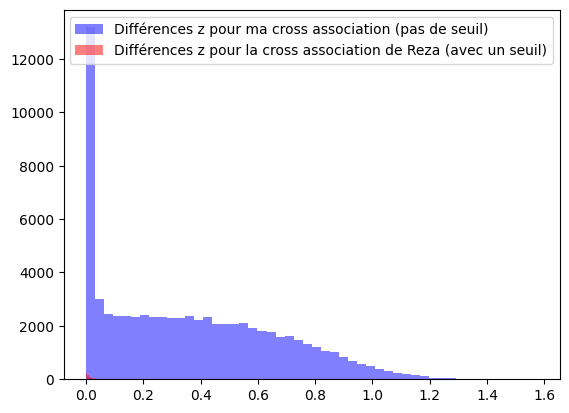

In [104]:
# Sans seuil sur z 
diff_z_list_flatten = [item for sublist in diff_z_list for item in sublist] # On 'flatten' id_assos_list
plt.hist(diff_z_list_flatten,bins=50,label='Différences z pour ma cross association (pas de seuil)',color='blue',alpha=0.5)
plt.hist(np.abs(clx_catass_df_crossed['delz']),bins=50,label='Différences z pour la cross association de Reza (avec un seuil)',color='red',alpha=0.5)
plt.legend()

# Pourquoi il n'y a qu'un seul delz pour un objet avec plusieurs associations optiques dans clx_catass_df → seule diff_z la plus faible est prise en compte dans catass (mais il y a don d'autres diff_z 'valides'<0.15
# qui sont ignorés)

## Projection "eliptique"

In [105]:
## On récupère les différentes coordonnées

# objets X associés
raj2000_x_crossed_list = table_X_crossed['RAJ2000'].tolist()
dej2000_x_crossed_list = table_X_crossed['DEJ2000'].tolist()

# optiques associées
raj2000_opt_crossed_list = table_optique_associated['RAJ2000'].tolist()
dej2000_opt_crossed_list = table_optique_associated['DEJ2000'].tolist()

# objets X
raj2000_x_list = table_X['RAJ2000'].tolist()
dej2000_x_list = table_X['DEJ2000'].tolist()

# objets optiques
raj2000_opt_list = table_optique['RAJ2000'].tolist()
dej2000_opt_list = table_optique['DEJ2000'].tolist()




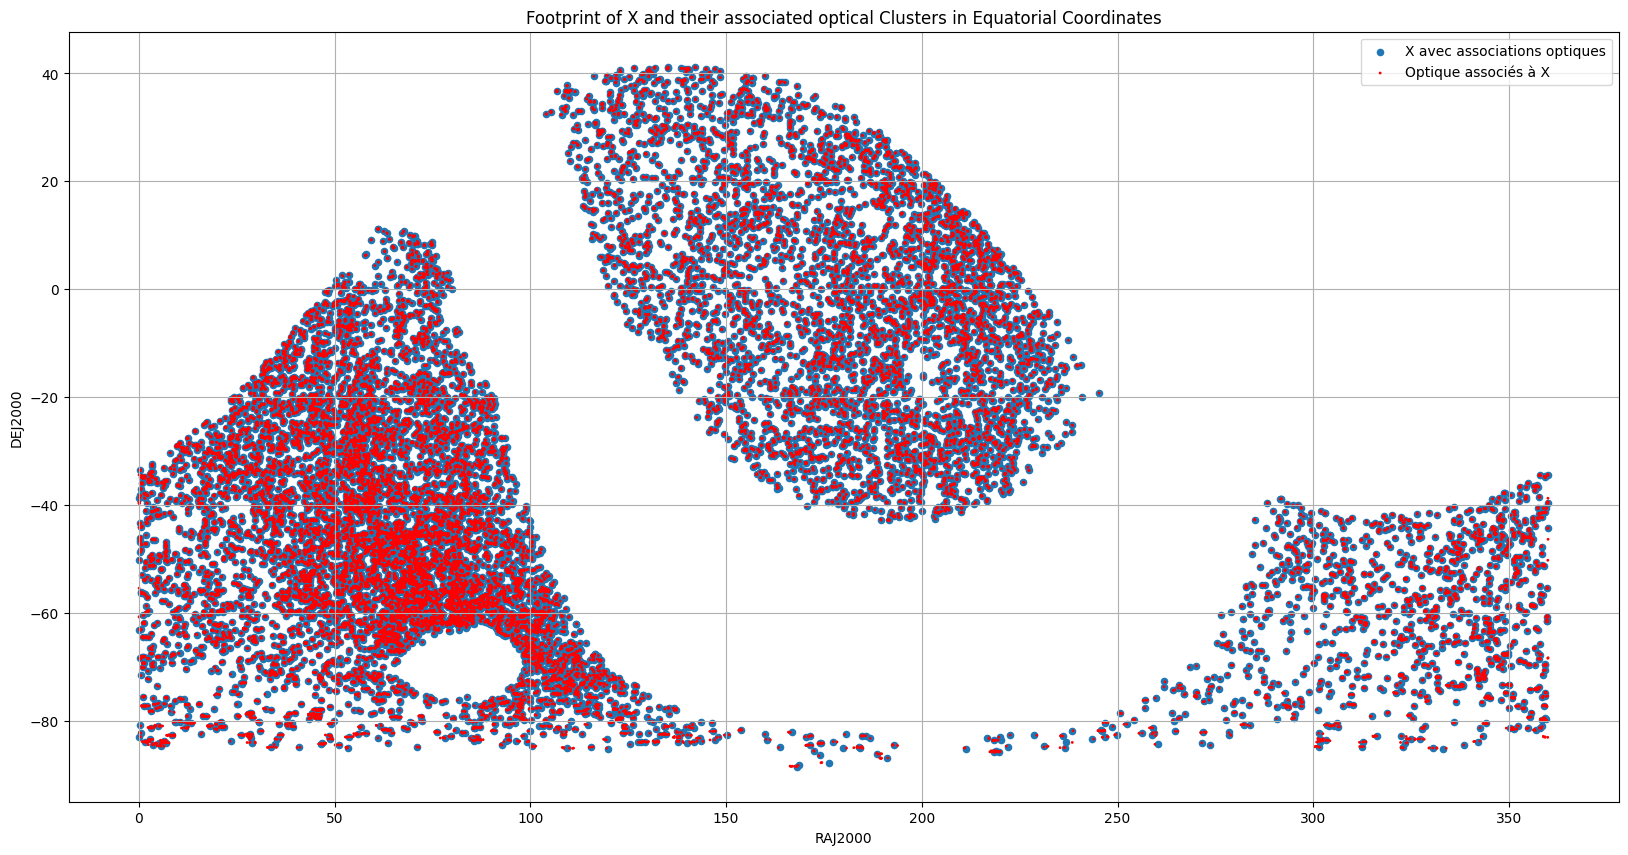

In [106]:
# Affiche les objets X et optiques associés : permet de cérifier si l'association fonctionne

plt.figure(figsize=(20, 10))
ax_projection_X = plt.subplot(111)
ax_projection_opt = plt.subplot(111)

ax_projection_X.scatter(raj2000_x_crossed_list, dej2000_x_crossed_list, s=20,label='X avec associations optiques') 
ax_projection_X.grid(True)
ax_projection_X.set_xlabel("RAJ2000")
ax_projection_X.set_ylabel("DEJ2000")

ax_projection_opt.scatter(raj2000_opt_crossed_list, dej2000_opt_crossed_list, s=1,edgecolors='red',facecolors='none',label='Optique associés à X') 
ax_projection_opt.grid(True)
ax_projection_opt.set_xlabel("RAJ2000")
ax_projection_opt.set_ylabel("DEJ2000")

plt.title(f"Footprint of X and their associated optical Clusters in Equatorial Coordinates")
plt.legend()


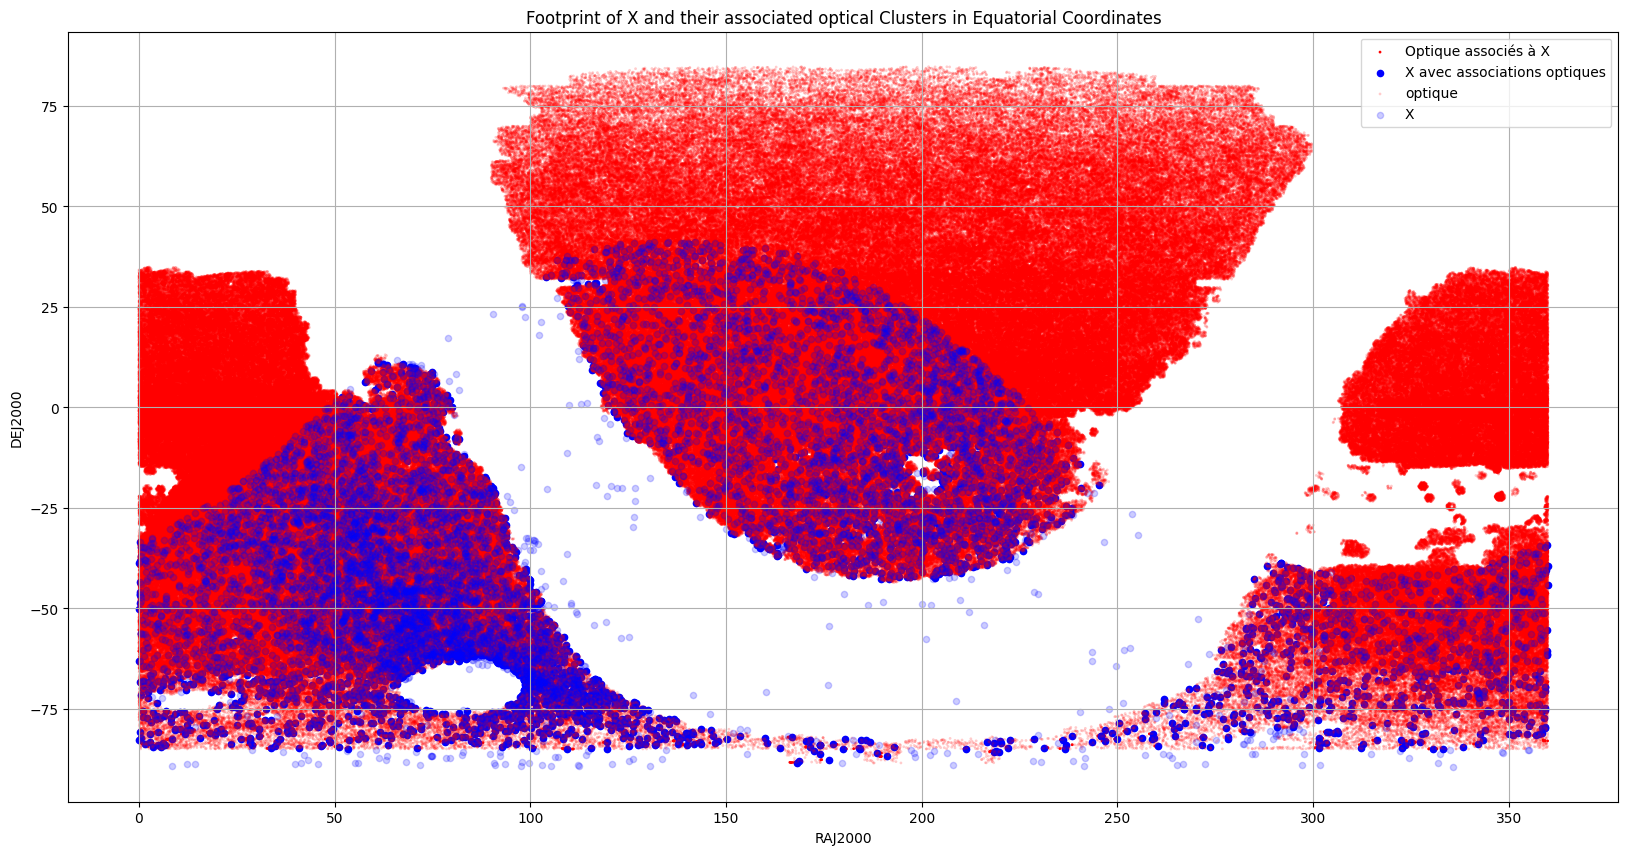

In [107]:
#On projette la footprint des associations ainsi que l'ensemble des objets X et optique


plt.figure(figsize=(20, 10))
ax_projection_X = plt.subplot(111)
ax_projection_opt = plt.subplot(111)
ax_projection_X_all = plt.subplot(111)
ax_projection_opt_all = plt.subplot(111)



ax_projection_opt.scatter(raj2000_opt_crossed_list, dej2000_opt_crossed_list, s=1,edgecolors='red',facecolors='none',label='Optique associés à X') 
ax_projection_opt.grid(True)
ax_projection_opt.set_xlabel("RAJ2000")
ax_projection_opt.set_ylabel("DEJ2000")

ax_projection_X.scatter(raj2000_x_crossed_list, dej2000_x_crossed_list, s=20,facecolors='blue',label='X avec associations optiques') 
ax_projection_X.grid(True)
ax_projection_X.set_xlabel("RAJ2000")
ax_projection_X.set_ylabel("DEJ2000")

ax_projection_opt_all.scatter(raj2000_opt_list, dej2000_opt_list,s=1,edgecolors='red',facecolors='none',alpha=0.2,label='optique') 
ax_projection_opt_all.grid(True)
ax_projection_opt_all.set_xlabel("RAJ2000")
ax_projection_opt_all.set_ylabel("DEJ2000")

ax_projection_X_all.scatter(raj2000_x_list, dej2000_x_list, s=20,facecolors='blue',alpha=0.2,label='X') 
ax_projection_X_all.grid(True)
ax_projection_X_all.set_xlabel("RAJ2000")
ax_projection_X_all.set_ylabel("DEJ2000")

plt.title(f"Footprint of X and their associated optical Clusters in Equatorial Coordinates")
plt.legend()



In [108]:
#Transformation des coordonnées galactiques en listes

X_crossed_glon = table_X_crossed['glon'].tolist() ; X_crossed_glat = table_X_crossed['glat'].tolist()
X_glon = table_X['glon'].tolist() ; X_glat = table_X['glat'].tolist()


opt_crossed_glon = table_optique_associated['glon'].tolist() ; opt_crossed_glat = table_optique_associated['glat'].tolist()
opt_glon = table_optique['glon'].tolist() ; opt_glat = table_optique['glat'].tolist()


C:\Users\ED282972\AppData\Roaming\Python\Python313\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\ED282972\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


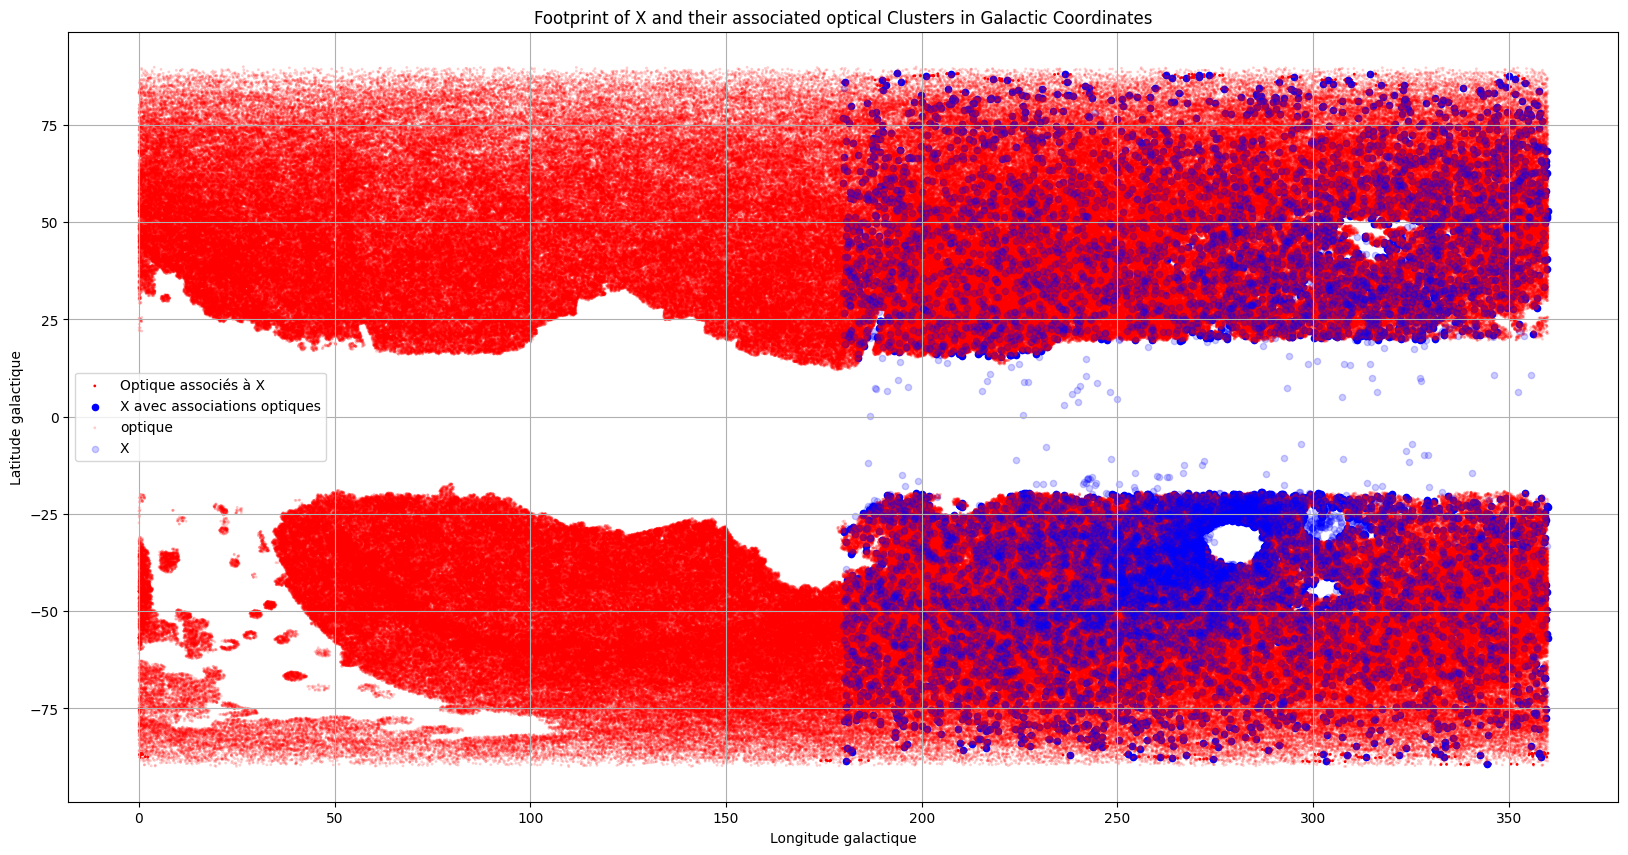

In [109]:
#La même chose en coordonnées galactiques

plt.figure(figsize=(20, 10))
ax_projection_X = plt.subplot(111)
ax_projection_opt = plt.subplot(111)
ax_projection_X_all = plt.subplot(111)
ax_projection_opt_all = plt.subplot(111)




ax_projection_opt.scatter(opt_crossed_glon, opt_crossed_glat, s=1,edgecolors='red',facecolors='none',label='Optique associés à X') 
ax_projection_opt.grid(True)
ax_projection_opt.set_xlabel("Longitude galactique")
ax_projection_opt.set_ylabel("Latitude galactique")

ax_projection_X.scatter(X_crossed_glon, X_crossed_glat, s=20,facecolors='blue',label='X avec associations optiques') 
ax_projection_X.grid(True)
ax_projection_X.set_xlabel("Longitude galactique")
ax_projection_X.set_ylabel("Latitude galactique")

ax_projection_opt_all.scatter(opt_glon, opt_glat,s=1,edgecolors='red',facecolors='none',alpha=0.2,label='optique') 
ax_projection_opt_all.grid(True)
ax_projection_opt_all.set_xlabel("Longitude galactique")
ax_projection_opt_all.set_ylabel("Latitude galactique")

ax_projection_X_all.scatter(X_glon, X_glat, s=20,facecolors='blue',alpha=0.2,label='X') 
ax_projection_X_all.grid(True)
ax_projection_X_all.set_xlabel("Longitude galactique")
ax_projection_X_all.set_ylabel("Latitude galactique")

plt.title(f"Footprint of X and their associated optical Clusters in Galactic Coordinates")
plt.legend()


# Sélection zone cross-matchs et étude spécifique

In [ ]:
# On commence par sélectionner sur les coordonnées galactiques
min_glon = min(X_glon) # eRASS1 ne concerne que l'hémisphère ouest


borne_1_glat = -35
borne_2_glat = 25

' Ne peut pas marcher car le fait de sélectionner en longitude ou en latittude ne conservent pas le même nombre de points\nopt_crossed_glon_selected = [glon for glon in opt_crossed_glon if glon >= min_glon]\nopt_crossed_glat_selected = [glat for glat in opt_crossed_glat if (glat <= borne_1_glat or glat >= borne_2_glat)] \n\nX_crossed_glon_selected = [glon for glon in X_crossed_glon if glon >= min_glon]\nX_crossed_glat_selected = [glat for glat in X_crossed_glat if (glat <= borne_1_glat or glat >= borne_2_glat)]\n'

In [ ]:
#On sélectionne la zone d'intérêt 
min_ra = 110 ; max_ra = 250
min_dec = -45 ; max_dec = 45

# On peut agrandir ou rétrécir très légérement certaines zones afin d'obtenir le même nombre d'éléments dans les tables X et optique
table_X_crossed_selected = table_X_crossed[(table_X_crossed['glon'] > min_glon)
                                           & ((table_X_crossed['glat'] >= borne_2_glat) | (table_X_crossed['glat'] <= borne_1_glat))
                                           ]

table_optique_associated_selected = table_optique_associated[(table_optique_associated['glon'] > min_glon)
                                           & ((table_optique_associated['glat'] >= borne_2_glat) | (table_optique_associated['glat'] <= borne_1_glat))
                                             ]


table_X_crossed_3D_selected = table_X_crossed_3D[(table_X_crossed_3D['glon'] > min_glon)
                              & ((table_X_crossed_3D['glat'] >= borne_2_glat) | (table_X_crossed_3D['glat'] <= borne_1_glat))
                            ] 

table_optique_associated_3D_selected = table_optique_associated_3D[(table_optique_associated_3D['glon'] > min_glon)
                              & ((table_optique_associated_3D['glat'] >= borne_2_glat) | (table_optique_associated_3D['glat'] <= borne_1_glat))
                            ]                                                                


In [114]:
table_optique_associated_3D_selected

glon       glat  _RAJ2000  _DEJ2000      ID n_Name  \
556     322.446478 -65.007926   0.13626 -50.14802     557          
732     327.071098 -68.285006   0.18620 -46.39547     733          
784     326.796035 -68.138090   0.20015 -46.57412     785          
946698  327.386929 -68.340662   0.08565 -46.28638  946699          
1060    331.863864 -70.856247   0.26207 -43.33034    1061    WH-   
...            ...        ...       ...       ...     ...    ...   
143248  266.170848 -69.180995  29.71560 -42.81436  143249    WH-   
143428  266.064887 -69.178425  29.75340 -42.78875  143429    WH-   
152564  285.568671 -56.066134  31.44418 -58.48524  152565    WH-   
162648  226.246398 -71.782423  33.38567 -29.81520  162649          
162830  226.291619 -71.752295  33.41935 -29.83114  162831    WH-   

                    Name   RAJ2000   DEJ2000     zCl  ...  logMs   r500  \
556     J000032.7-500853   0.13626 -50.14802  0.0887  ...  11.57  0.564   
732     J000044.7-462344   0.18620 -46.39547  0.1042  ...  11.84  0.777   
784     J000048.0-463427   0.20015 -46.57412  0.2052  ...  11.86  0.841   
946698  J000020.6-461711   0.08565 -46.28638  0.1865  ...  11.55  0.760   
1060    J000102.9-431949   0.26207 -43.33034  0.0388  ...  11.57  0.570   
...                  ...       ...       ...     ...  ...    ...    ...   
143248  J015851.7-424852  29.71560 -42.81436  1.2124  ...  11.11  0.392   
143428  J015900.8-424719  29.75340 -42.78875  1.1048  ...  11.52  0.468   
152564  J020546.6-582907  31.44418 -58.48524  1.4351  ...  11.36  0.530   
162648  J021332.6-294855  33.38567 -29.81520  1.2620  ...  11.55  0.582   
162830  J021340.6-294952  33.41935 -29.83114  1.2757  ...  11.32  0.486   

        lam500  M500  Ngal  Gamma  e_Gamma  imag_        Cat   recno  
556      14.80   6.8     8    0.0      0.0      1  WaZP          557  
732      30.92  14.0    13    0.0      0.0      1  CFSFDP        733  
784      44.39  19.9    18    0.0      0.0      1  WHY18         785  
946698   34.57  15.6    13    0.0      0.0      2  Y21        946699  
1060     13.78   6.4     7    0.0      0.0      1               1061  
...        ...   ...   ...    ...      ...    ...        ...     ...  
143248   10.11   4.7     6    0.0      0.0      1             143249  
143428   12.06   5.6     7    0.0      0.0      1             143429  
152564   33.33  15.0     9    0.0      0.0      1             152565  
162648   41.67  18.7    17    0.0      0.0      1  WH22       162649  
162830   25.47  11.6    10    0.0      0.0      1             162831  

[17618 rows x 23 columns]

In [115]:
table_optique_associated_3D

glon       glat  _RAJ2000  _DEJ2000      ID n_Name  \
695     304.837662 -34.141389   0.17682 -82.79820     696    WH-   
556     322.446478 -65.007926   0.13626 -50.14802     557          
732     327.071098 -68.285006   0.18620 -46.39547     733          
784     326.796035 -68.138090   0.20015 -46.57412     785          
946698  327.386929 -68.340662   0.08565 -46.28638  946699          
...            ...        ...       ...       ...     ...    ...   
143428  266.064887 -69.178425  29.75340 -42.78875  143429    WH-   
152564  285.568671 -56.066134  31.44418 -58.48524  152565    WH-   
162648  226.246398 -71.782423  33.38567 -29.81520  162649          
162830  226.291619 -71.752295  33.41935 -29.83114  162831    WH-   
417600  265.917064 -24.157058  99.52448 -56.61699  417601    WH-   

                    Name   RAJ2000   DEJ2000     zCl  ...  logMs   r500  \
695     J000042.4-824754   0.17682 -82.79820  0.0862  ...  11.47  0.557   
556     J000032.7-500853   0.13626 -50.14802  0.0887  ...  11.57  0.564   
732     J000044.7-462344   0.18620 -46.39547  0.1042  ...  11.84  0.777   
784     J000048.0-463427   0.20015 -46.57412  0.2052  ...  11.86  0.841   
946698  J000020.6-461711   0.08565 -46.28638  0.1865  ...  11.55  0.760   
...                  ...       ...       ...     ...  ...    ...    ...   
143428  J015900.8-424719  29.75340 -42.78875  1.1048  ...  11.52  0.468   
152564  J020546.6-582907  31.44418 -58.48524  1.4351  ...  11.36  0.530   
162648  J021332.6-294855  33.38567 -29.81520  1.2620  ...  11.55  0.582   
162830  J021340.6-294952  33.41935 -29.83114  1.2757  ...  11.32  0.486   
417600  J063805.9-563701  99.52448 -56.61699  1.1412  ...  12.05  0.636   

        lam500  M500  Ngal  Gamma  e_Gamma  imag_        Cat   recno  
695      11.16   5.2     9    0.0      0.0      1                696  
556      14.80   6.8     8    0.0      0.0      1  WaZP          557  
732      30.92  14.0    13    0.0      0.0      1  CFSFDP        733  
784      44.39  19.9    18    0.0      0.0      1  WHY18         785  
946698   34.57  15.6    13    0.0      0.0      2  Y21        946699  
...        ...   ...   ...    ...      ...    ...        ...     ...  
143428   12.06   5.6     7    0.0      0.0      1             143429  
152564   33.33  15.0     9    0.0      0.0      1             152565  
162648   41.67  18.7    17    0.0      0.0      1  WH22       162649  
162830   25.47  11.6    10    0.0      0.0      1             162831  
417600   47.71  21.3     6    0.0      0.0      1             417601  

[22865 rows x 23 columns]

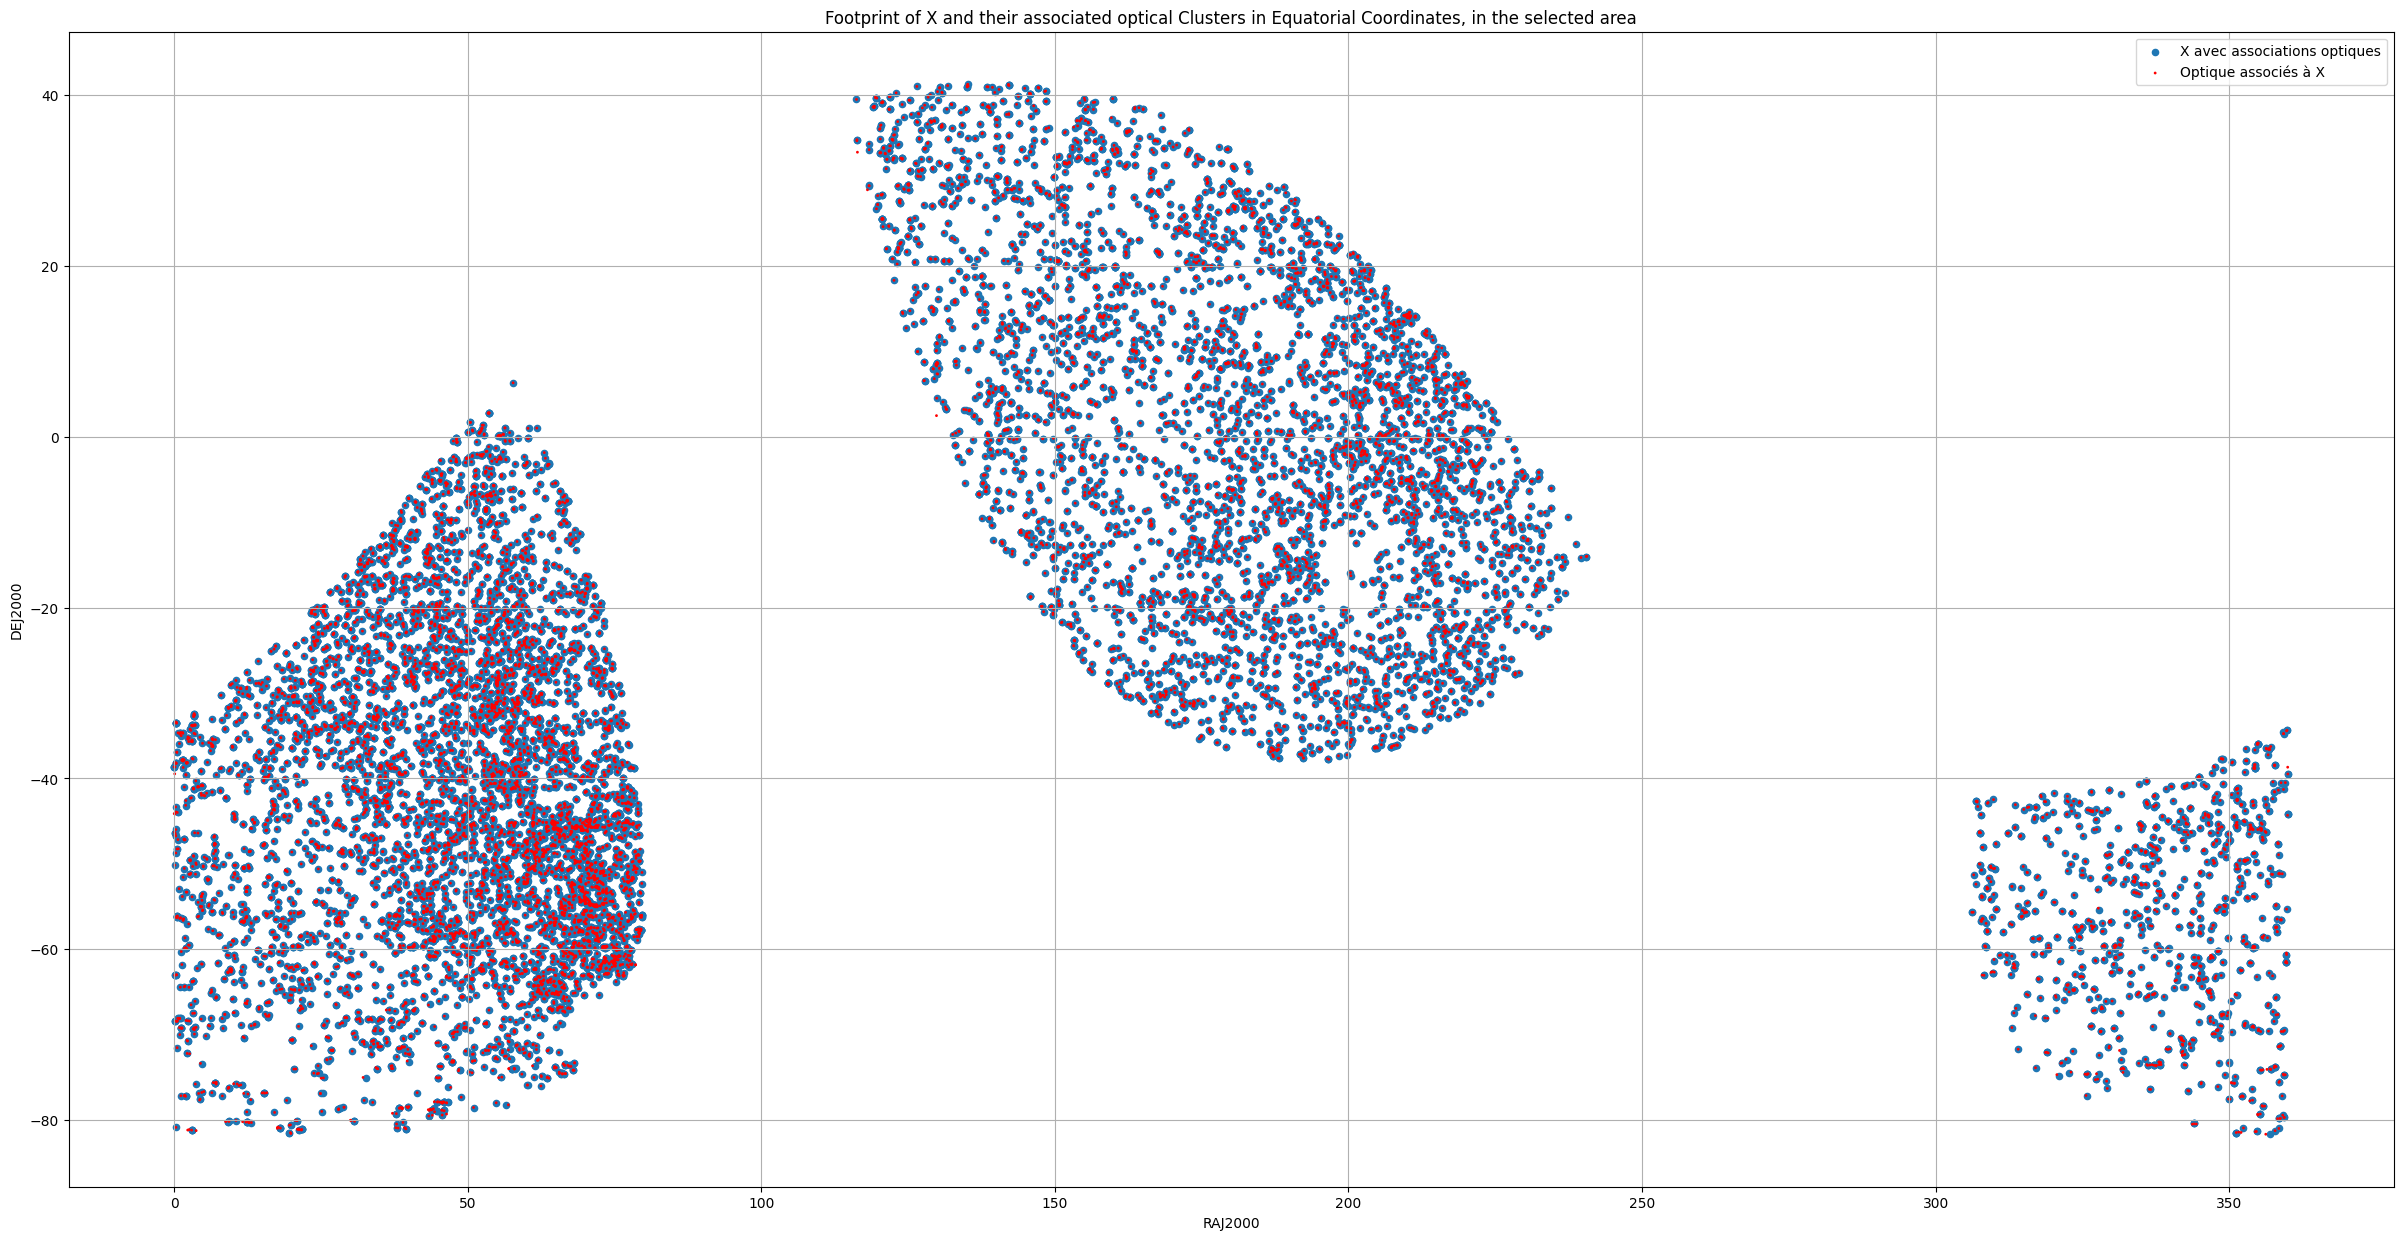

In [116]:
#On projette les footprint de la zone sélectionnée

raj2000_x_crossed_list_selected = table_X_crossed_3D_selected['RAJ2000'].tolist()
dej2000_x_crossed_list_seleceted = table_X_crossed_3D_selected['DEJ2000'].tolist()

raj2000_opt_crossed_list_selected = table_optique_associated_3D_selected['RAJ2000'].tolist()
dej2000_opt_crossed_list_seleceted = table_optique_associated_3D_selected['DEJ2000'].tolist()

plt.figure(figsize=(30, 15))
ax_projection_X = plt.subplot(111)
ax_projection_opt = plt.subplot(111)

ax_projection_X.scatter(raj2000_x_crossed_list_selected, dej2000_x_crossed_list_seleceted, s=20,label='X avec associations optiques') 
ax_projection_X.grid(True)
ax_projection_X.set_xlabel("RAJ2000")
ax_projection_X.set_ylabel("DEJ2000")

ax_projection_opt.scatter(raj2000_opt_crossed_list_selected, dej2000_opt_crossed_list_seleceted, s=1,edgecolors='red',facecolors='none',label='Optique associés à X') 
ax_projection_opt.grid(True)
ax_projection_opt.set_xlabel("RAJ2000")
ax_projection_opt.set_ylabel("DEJ2000")

plt.title(f"Footprint of X and their associated optical Clusters in Equatorial Coordinates, in the selected area")
plt.legend()


## Diagramme N-M / M-M

In [126]:
table_X_crossed_3D_selected

__indexes        glon       glat   _RAJ2000   _DEJ2000  \
2             2  322.452378 -65.003242   0.129422 -50.151013   
4             4  327.067389 -68.286560   0.189080 -46.394874   
4             4  327.067389 -68.286560   0.189080 -46.394874   
4             4  327.067389 -68.286560   0.189080 -46.394874   
7             7  331.849050 -70.856252   0.267457 -43.333211   
...         ...         ...        ...        ...        ...   
840         840  266.066668 -69.175450  29.755758 -42.791252   
840         840  266.066668 -69.175450  29.755758 -42.791252   
918         918  285.564459 -56.066281  31.447911 -58.483919   
1007       1007  226.318506 -71.777304  33.389983 -29.838015   
1007       1007  226.318506 -71.777304  33.389983 -29.838015   

                         Name    RAJ2000    DEJ2000         Exp   zBest  ...  \
2     1eRASS J000031.0-500903   0.129422 -50.151013  117.300003  0.0681  ...   
4     1eRASS J000045.3-462341   0.189080 -46.394874  109.500000  0.0925  ...   
4     1eRASS J000045.3-462341   0.189080 -46.394874  109.500000  0.0925  ...   
4     1eRASS J000045.3-462341   0.189080 -46.394874  109.500000  0.0925  ...   
7     1eRASS J000104.1-431959   0.267457 -43.333211   99.800003  0.0381  ...   
...                       ...        ...        ...         ...     ...  ...   
840   1eRASS J015901.3-424728  29.755758 -42.791252  145.800003  1.2192  ...   
840   1eRASS J015901.3-424728  29.755758 -42.791252  145.800003  1.2192  ...   
918   1eRASS J020547.4-582902  31.447911 -58.483919  158.600006  1.3219  ...   
1007  1eRASS J021333.5-295016  33.389983 -29.838015  176.800003  1.2400  ...   
1007  1eRASS J021333.5-295016  33.389983 -29.838015  176.800003  1.2400  ...   

         L500    KT     Mgas500  YX500   M500  Fgas500        R500  id_asso  \
2       2.862  1.79    1.920000   9.34   3.63    0.009         493      556   
4       3.996  0.96    6.400000  11.17   3.78    0.019         495      732   
4       3.996  0.96    6.400000  11.17   3.78    0.019         495      784   
4       3.996  0.96    6.400000  11.17   3.78    0.019         495   946698   
7         NaN   NaN         NaN    NaN    NaN      NaN -2147483648     1060   
...       ...   ...         ...    ...    ...      ...         ...      ...   
840       NaN   NaN         NaN    NaN    NaN      NaN -2147483648   143248   
840       NaN   NaN         NaN    NaN    NaN      NaN -2147483648   143428   
918   527.266   NaN  122.699997   0.00  22.92    0.055         565   152564   
1007      NaN   NaN         NaN    NaN    NaN      NaN -2147483648   162648   
1007      NaN   NaN         NaN    NaN    NaN      NaN -2147483648   162830   

      diff_z  dist_ang  
2     0.0206  0.007464  
4     0.0117  0.002941  
4     0.1127  0.179588  
4     0.0940  0.149895  
7     0.0007  0.006105  
...      ...       ...  
840   0.0068  0.046332  
840   0.1144  0.003438  
918   0.1132  0.003958  
1007  0.0220  0.023219  
1007  0.0357  0.030161  

[17628 rows x 28 columns]

In [127]:
index_optique_associated_3D_selected = table_optique_associated_3D_selected.index.tolist()
table_optique_associated_3D_selected['__indexes'] = index_optique_associated_3D_selected
table_optique_associated_3D_selected = table_optique_associated_3D_selected[['__indexes'] + [col for col in table_optique_associated_3D_selected.columns if col != '__indexes']]
table_optique_associated_3D_selected

__indexes        glon       glat  _RAJ2000  _DEJ2000      ID n_Name  \
556           556  322.446478 -65.007926   0.13626 -50.14802     557          
732           732  327.071098 -68.285006   0.18620 -46.39547     733          
784           784  326.796035 -68.138090   0.20015 -46.57412     785          
946698     946698  327.386929 -68.340662   0.08565 -46.28638  946699          
1060         1060  331.863864 -70.856247   0.26207 -43.33034    1061    WH-   
...           ...         ...        ...       ...       ...     ...    ...   
143248     143248  266.170848 -69.180995  29.71560 -42.81436  143249    WH-   
143428     143428  266.064887 -69.178425  29.75340 -42.78875  143429    WH-   
152564     152564  285.568671 -56.066134  31.44418 -58.48524  152565    WH-   
162648     162648  226.246398 -71.782423  33.38567 -29.81520  162649          
162830     162830  226.291619 -71.752295  33.41935 -29.83114  162831    WH-   

                    Name   RAJ2000   DEJ2000  ...  logMs   r500  lam500  M500  \
556     J000032.7-500853   0.13626 -50.14802  ...  11.57  0.564   14.80   6.8   
732     J000044.7-462344   0.18620 -46.39547  ...  11.84  0.777   30.92  14.0   
784     J000048.0-463427   0.20015 -46.57412  ...  11.86  0.841   44.39  19.9   
946698  J000020.6-461711   0.08565 -46.28638  ...  11.55  0.760   34.57  15.6   
1060    J000102.9-431949   0.26207 -43.33034  ...  11.57  0.570   13.78   6.4   
...                  ...       ...       ...  ...    ...    ...     ...   ...   
143248  J015851.7-424852  29.71560 -42.81436  ...  11.11  0.392   10.11   4.7   
143428  J015900.8-424719  29.75340 -42.78875  ...  11.52  0.468   12.06   5.6   
152564  J020546.6-582907  31.44418 -58.48524  ...  11.36  0.530   33.33  15.0   
162648  J021332.6-294855  33.38567 -29.81520  ...  11.55  0.582   41.67  18.7   
162830  J021340.6-294952  33.41935 -29.83114  ...  11.32  0.486   25.47  11.6   

        Ngal  Gamma  e_Gamma  imag_        Cat   recno  
556        8    0.0      0.0      1  WaZP          557  
732       13    0.0      0.0      1  CFSFDP        733  
784       18    0.0      0.0      1  WHY18         785  
946698    13    0.0      0.0      2  Y21        946699  
1060       7    0.0      0.0      1               1061  
...      ...    ...      ...    ...        ...     ...  
143248     6    0.0      0.0      1             143249  
143428     7    0.0      0.0      1             143429  
152564     9    0.0      0.0      1             152565  
162648    17    0.0      0.0      1  WH22       162649  
162830    10    0.0      0.0      1             162831  

[17618 rows x 24 columns]

In [135]:
# On a pas exactement le même nombre de lignes dans "table_X_crossed_3D_selected" et "table_optique_associated_3D_selected" du fait que la sélection de zone laissent passer quelques objets de trop optiques ou X selon le cas
# On filtre donc la table_optique "table_optique_associated_3D_selected"

if len(table_X_crossed_3D_selected) > len(table_optique_associated_3D_selected):
    table_X_crossed_3D_selected_filtered = table_X_crossed_3D_selected[table_X_crossed_3D_selected['id_asso'].isin(table_optique_associated_3D_selected['__indexes'].tolist())]
    table_optique_associated_3D_selected_filtered = table_optique_associated_3D_selected[table_optique_associated_3D_selected['__indexes'].isin(table_X_crossed_3D_selected_filtered['id_asso'].tolist())]

In [162]:
# Perform iterative filtering to ensure both DataFrames have the same number of rows
max_iterations = 100  # Set a maximum number of iterations to prevent infinite loops
iteration = 0

while iteration < max_iterations:
    iteration += 1
    
    # Find the common indexes between the two DataFrames
    common_indexes = set(table_optique_associated_3D_selected['__indexes']).intersection(
        set(table_X_crossed_3D_selected['id_asso'])
    )
    
    # Filter both DataFrames using the common indexes
    table_X_crossed_3D_selected_filtered = table_X_crossed_3D_selected[
        table_X_crossed_3D_selected['id_asso'].isin(common_indexes)
    ]
    table_optique_associated_3D_selected_filtered = table_optique_associated_3D_selected[
        table_optique_associated_3D_selected['__indexes'].isin(common_indexes)
    ]
    
    # Check if the lengths of the filtered DataFrames are the same
    if len(table_X_crossed_3D_selected_filtered) == len(table_optique_associated_3D_selected_filtered):
        print(f"Converged after {iteration} iterations.")
        break  # Exit the loop if they are aligned
    
    # Update the original DataFrames for the next iteration
    table_X_crossed_3D_selected = table_X_crossed_3D_selected_filtered
    table_optique_associated_3D_selected = table_optique_associated_3D_selected_filtered

# If the loop exceeds the maximum number of iterations, raise an error
if iteration == max_iterations:
    print("Warning: Maximum iterations reached. The DataFrames may not be fully aligned.")

# Verify the result
print(len(table_X_crossed_3D_selected_filtered), len(table_optique_associated_3D_selected_filtered))

17610 17611


In [ ]:
### PROBLEME FILTRAGE !!!

# Find the exact intersection of the 'id_asso' and '__indexes' columns
common_indexes = set(table_X_crossed_3D_selected['id_asso']).intersection(
    set(table_optique_associated_3D_selected['__indexes'])
)

# Filter both DataFrames using the common indexes
table_X_crossed_3D_selected_filtered = table_X_crossed_3D_selected[
    table_X_crossed_3D_selected['id_asso'].isin(common_indexes)
]
table_optique_associated_3D_selected_filtered = table_optique_associated_3D_selected[
    table_optique_associated_3D_selected['__indexes'].isin(common_indexes)
]

# Verify the result
print(len(table_X_crossed_3D_selected_filtered), len(table_optique_associated_3D_selected_filtered))

17610 17611


In [148]:
indexes_to_remove = set(table_optique_associated_3D_selected_filtered['__indexes']) - set(table_X_crossed_3D_selected_filtered['id_asso'])


In [149]:
indexes_to_remove

set()

In [153]:
table_optique_associated_3D_selected_filtered

__indexes        glon       glat  _RAJ2000  _DEJ2000      ID n_Name  \
556           556  322.446478 -65.007926   0.13626 -50.14802     557          
732           732  327.071098 -68.285006   0.18620 -46.39547     733          
784           784  326.796035 -68.138090   0.20015 -46.57412     785          
946698     946698  327.386929 -68.340662   0.08565 -46.28638  946699          
1060         1060  331.863864 -70.856247   0.26207 -43.33034    1061    WH-   
...           ...         ...        ...       ...       ...     ...    ...   
143248     143248  266.170848 -69.180995  29.71560 -42.81436  143249    WH-   
143428     143428  266.064887 -69.178425  29.75340 -42.78875  143429    WH-   
152564     152564  285.568671 -56.066134  31.44418 -58.48524  152565    WH-   
162648     162648  226.246398 -71.782423  33.38567 -29.81520  162649          
162830     162830  226.291619 -71.752295  33.41935 -29.83114  162831    WH-   

                    Name   RAJ2000   DEJ2000  ...  logMs   r500  lam500  M500  \
556     J000032.7-500853   0.13626 -50.14802  ...  11.57  0.564   14.80   6.8   
732     J000044.7-462344   0.18620 -46.39547  ...  11.84  0.777   30.92  14.0   
784     J000048.0-463427   0.20015 -46.57412  ...  11.86  0.841   44.39  19.9   
946698  J000020.6-461711   0.08565 -46.28638  ...  11.55  0.760   34.57  15.6   
1060    J000102.9-431949   0.26207 -43.33034  ...  11.57  0.570   13.78   6.4   
...                  ...       ...       ...  ...    ...    ...     ...   ...   
143248  J015851.7-424852  29.71560 -42.81436  ...  11.11  0.392   10.11   4.7   
143428  J015900.8-424719  29.75340 -42.78875  ...  11.52  0.468   12.06   5.6   
152564  J020546.6-582907  31.44418 -58.48524  ...  11.36  0.530   33.33  15.0   
162648  J021332.6-294855  33.38567 -29.81520  ...  11.55  0.582   41.67  18.7   
162830  J021340.6-294952  33.41935 -29.83114  ...  11.32  0.486   25.47  11.6   

        Ngal  Gamma  e_Gamma  imag_        Cat   recno  
556        8    0.0      0.0      1  WaZP          557  
732       13    0.0      0.0      1  CFSFDP        733  
784       18    0.0      0.0      1  WHY18         785  
946698    13    0.0      0.0      2  Y21        946699  
1060       7    0.0      0.0      1               1061  
...      ...    ...      ...    ...        ...     ...  
143248     6    0.0      0.0      1             143249  
143428     7    0.0      0.0      1             143429  
152564     9    0.0      0.0      1             152565  
162648    17    0.0      0.0      1  WH22       162649  
162830    10    0.0      0.0      1             162831  

[17611 rows x 24 columns]

In [151]:
table_X_crossed_3D_selected_filtered

__indexes        glon       glat   _RAJ2000   _DEJ2000  \
2             2  322.452378 -65.003242   0.129422 -50.151013   
4             4  327.067389 -68.286560   0.189080 -46.394874   
4             4  327.067389 -68.286560   0.189080 -46.394874   
4             4  327.067389 -68.286560   0.189080 -46.394874   
7             7  331.849050 -70.856252   0.267457 -43.333211   
...         ...         ...        ...        ...        ...   
840         840  266.066668 -69.175450  29.755758 -42.791252   
840         840  266.066668 -69.175450  29.755758 -42.791252   
918         918  285.564459 -56.066281  31.447911 -58.483919   
1007       1007  226.318506 -71.777304  33.389983 -29.838015   
1007       1007  226.318506 -71.777304  33.389983 -29.838015   

                         Name    RAJ2000    DEJ2000         Exp   zBest  ...  \
2     1eRASS J000031.0-500903   0.129422 -50.151013  117.300003  0.0681  ...   
4     1eRASS J000045.3-462341   0.189080 -46.394874  109.500000  0.0925  ...   
4     1eRASS J000045.3-462341   0.189080 -46.394874  109.500000  0.0925  ...   
4     1eRASS J000045.3-462341   0.189080 -46.394874  109.500000  0.0925  ...   
7     1eRASS J000104.1-431959   0.267457 -43.333211   99.800003  0.0381  ...   
...                       ...        ...        ...         ...     ...  ...   
840   1eRASS J015901.3-424728  29.755758 -42.791252  145.800003  1.2192  ...   
840   1eRASS J015901.3-424728  29.755758 -42.791252  145.800003  1.2192  ...   
918   1eRASS J020547.4-582902  31.447911 -58.483919  158.600006  1.3219  ...   
1007  1eRASS J021333.5-295016  33.389983 -29.838015  176.800003  1.2400  ...   
1007  1eRASS J021333.5-295016  33.389983 -29.838015  176.800003  1.2400  ...   

         L500    KT     Mgas500  YX500   M500  Fgas500        R500  id_asso  \
2       2.862  1.79    1.920000   9.34   3.63    0.009         493      556   
4       3.996  0.96    6.400000  11.17   3.78    0.019         495      732   
4       3.996  0.96    6.400000  11.17   3.78    0.019         495      784   
4       3.996  0.96    6.400000  11.17   3.78    0.019         495   946698   
7         NaN   NaN         NaN    NaN    NaN      NaN -2147483648     1060   
...       ...   ...         ...    ...    ...      ...         ...      ...   
840       NaN   NaN         NaN    NaN    NaN      NaN -2147483648   143248   
840       NaN   NaN         NaN    NaN    NaN      NaN -2147483648   143428   
918   527.266   NaN  122.699997   0.00  22.92    0.055         565   152564   
1007      NaN   NaN         NaN    NaN    NaN      NaN -2147483648   162648   
1007      NaN   NaN         NaN    NaN    NaN      NaN -2147483648   162830   

      diff_z  dist_ang  
2     0.0206  0.007464  
4     0.0117  0.002941  
4     0.1127  0.179588  
4     0.0940  0.149895  
7     0.0007  0.006105  
...      ...       ...  
840   0.0068  0.046332  
840   0.1144  0.003438  
918   0.1132  0.003958  
1007  0.0220  0.023219  
1007  0.0357  0.030161  

[17610 rows x 28 columns]

In [ ]:
len(index_optique_associated_3D_selected)

17618

In [157]:
richness = table_optique_associated_3D_selected_filtered['lam500'] # Richness : mass proxy → define eq 2 in Wen 2024
M_500_opt = np.array(table_optique_associated_3D_selected_filtered['M500'])
M500_X = np.array(table_X_crossed_3D_selected_filtered['M500'])

In [158]:
'''richness_mass_associations = [(x, y) for x, y in zip(table_optique_associated_selected['N200'], table_X_crossed_3D_selected['M500'])]
richness_mass_associations_ = [(y, x) for x, y in zip(table_optique_associated_selected['N200'], table_X_crossed_3D_selected['M500'])]'''

"richness_mass_associations = [(x, y) for x, y in zip(table_optique_associated_selected['N200'], table_X_crossed_3D_selected['M500'])]\nrichness_mass_associations_ = [(y, x) for x, y in zip(table_optique_associated_selected['N200'], table_X_crossed_3D_selected['M500'])]"

ValueError: x and y must have same first dimension, but have shapes (17610,) and (17611,)

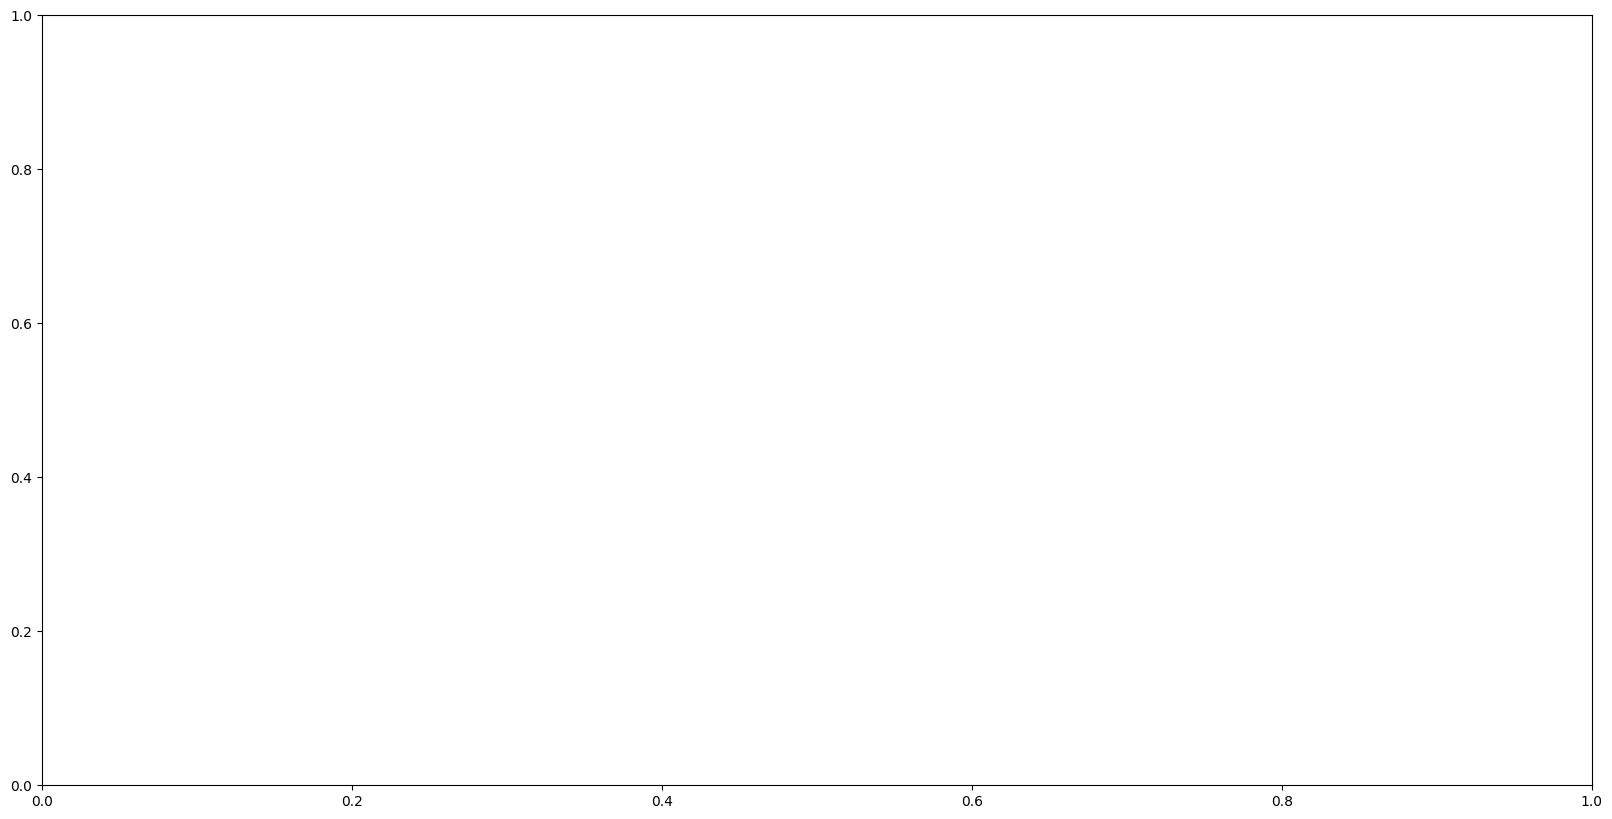

In [159]:
# graphe richess optique - M500

plt.figure(figsize=(20, 10))
plt.plot(M500_X,richness, 'o', markersize=3)
plt.plot(M_500_opt,richness, 'o',color = 'red', markersize=3)
plt.xlabel('M500 des objets X (10^13 Msun)')
plt.ylabel('lam500 (richesse optique)')
plt.title('Richesse optique en fonction de la masse des objets X associés')
plt.xscale('log')

Text(0.5, 1.0, 'Histogramme de la différence de M500 pour chaque association X - optique (10^13 Msun)')

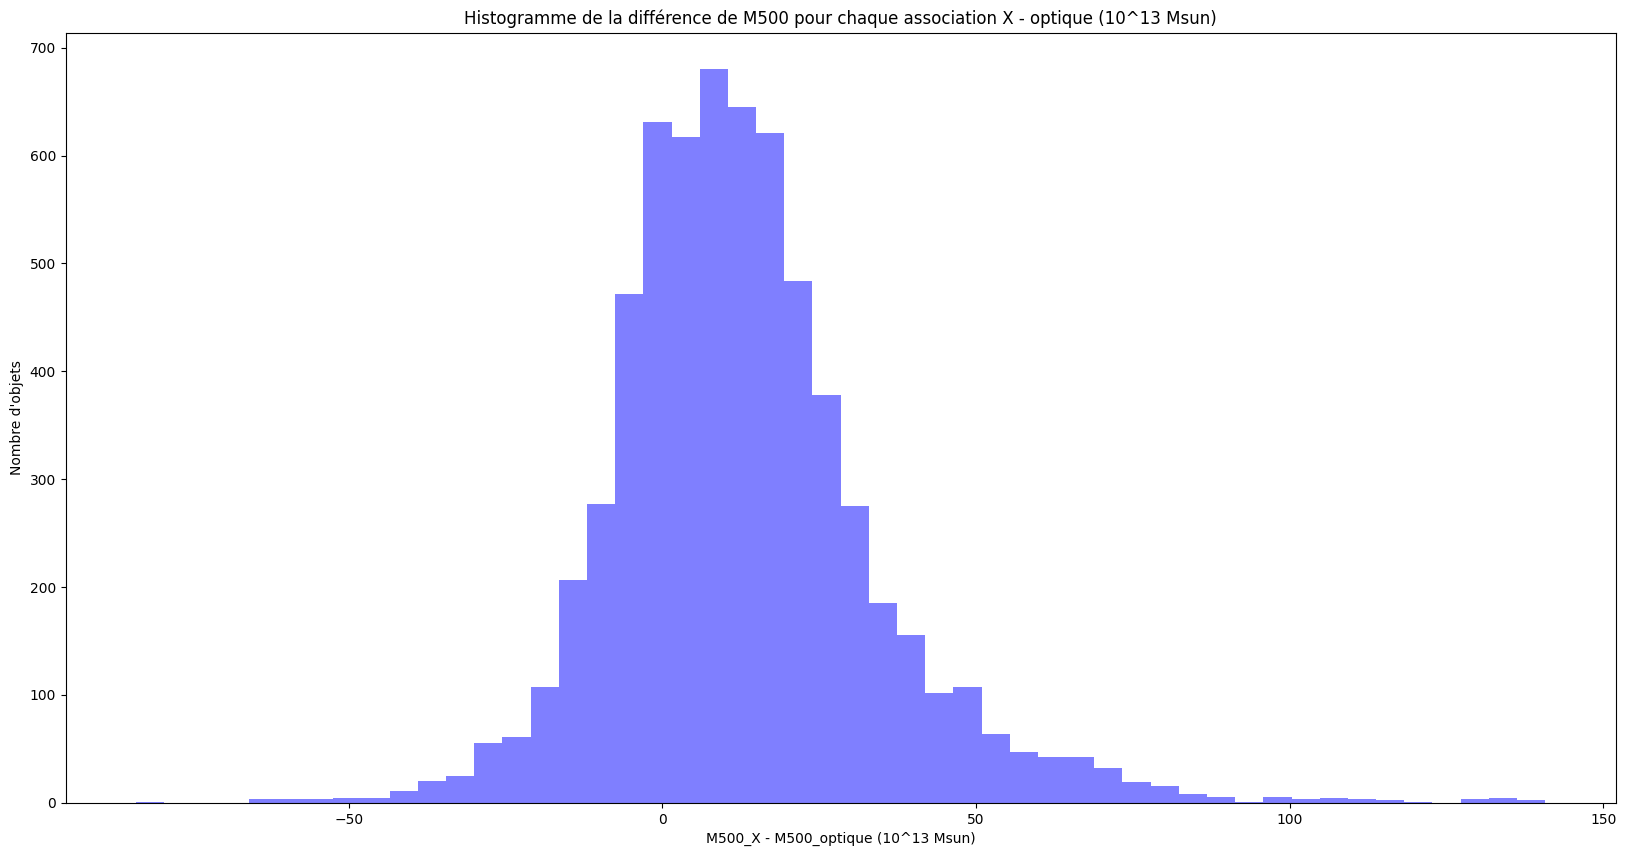

In [ ]:
# Histogramme M500_X - M500_optique
diff_mass = M500_X - M_500_opt

plt.figure(figsize=(20, 10))
plt.hist(diff_mass, bins=50, color='blue', alpha=0.5)
plt.xlabel('M500_X - M500_optique (10^13 Msun)')
plt.ylabel('Nombre d\'objets')
plt.title('Histogramme de la différence de M500 pour chaque association X - optique (10^13 Msun)')

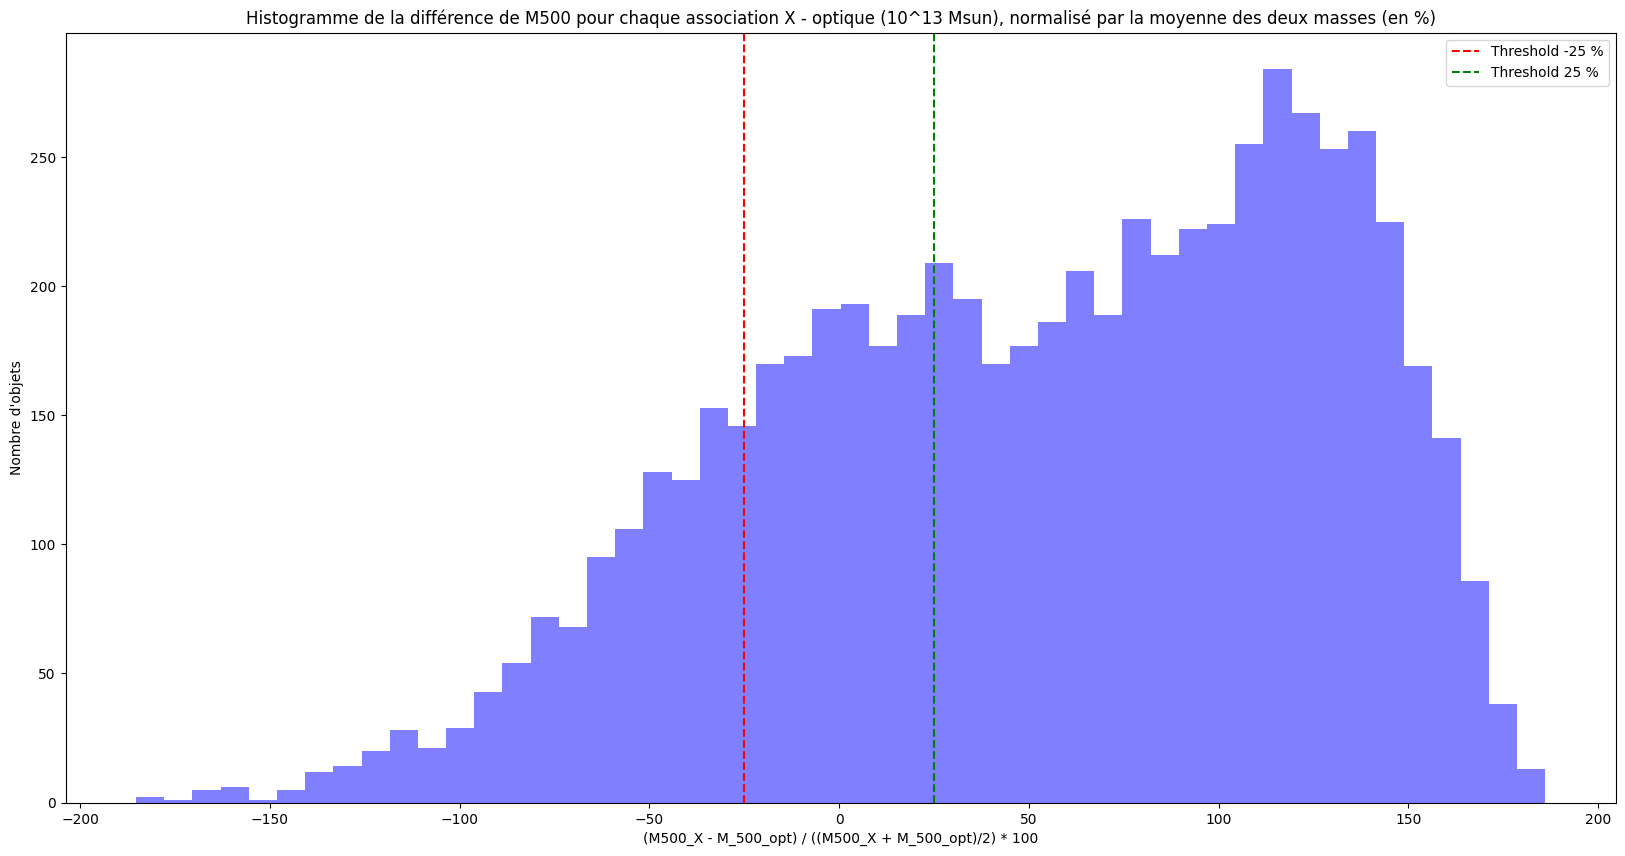

In [ ]:
diff_mass_normalisée = ((M500_X - M_500_opt) / ((M500_X + M_500_opt)/2))*100


plt.figure(figsize=(20, 10))
plt.hist(diff_mass_normalisée , bins=50, color='blue', alpha=0.5)

# Add thresholds
threshold1 = -25  # Example threshold
threshold2 = 25   # Example threshold
plt.axvline(x=threshold1, color='red', linestyle='--', label=f'Threshold {threshold1} %')
plt.axvline(x=threshold2, color='green', linestyle='--', label=f'Threshold {threshold2} %')

plt.xlabel('(M500_X - M_500_opt) / ((M500_X + M_500_opt)/2) * 100')
plt.ylabel('Nombre d\'objets')
plt.title('Histogramme de la différence de M500 pour chaque association X - optique (10^13 Msun), normalisé par la moyenne des deux masses (en %)')

plt.legend()

In [ ]:
# on récupère les indices des associations dont la différence de masse normalisée est supérieure à 25% (en valeur absolue)
suspect_associations_mass = []
for i in range(len(diff_mass_normalisée)):
    if abs(diff_mass_normalisée[i]) > 25:
        suspect_associations_mass.append(i)

suspect_associations_mass_indexes = np.zeros((len(suspect_associations_mass), 2))  # Initialize a 2D array with zeros
i = 0
for x in suspect_associations_mass:
    suspect_associations_mass_indexes[i][0] = table_X_crossed_3D_selected.iloc[x].name
    suspect_associations_mass_indexes[i][1] = table_optique_associated_3D_selected.iloc[x].name
    i += 1
suspect_associations_mass_indexes
suspect_associations_mass_indexes_X = suspect_associations_mass_indexes[:,0].astype(int)
suspect_associations_mass_indexes_opt = suspect_associations_mass_indexes[:,1].astype(int)

print("Proportion d'associations suspectes en termes de diffrences de masse par rapport au nombre total d'associations : ", round(len(suspect_associations_mass)/len(diff_mass_normalisée)*100,3), "%")

Proportion d'associations suspectes en termes de diffrences de masse par rapport au nombre total d'associations :  69.547 %


In [ ]:
suspect_associations_mass_indexes
table_X_crossed_3D_selected_suspect = table_X_crossed_3D_selected.loc[suspect_associations_mass_indexes_X] # On récupère les objets X des associations suspectes
table_optique_associated_3D_selected_suspect = table_optique_associated_3D_selected.loc[suspect_associations_mass_indexes_opt] # On récupère les objets optiques des associations suspectes

In [ ]:
table_X_crossed_3D_selected_suspect

__indexes    _RAJ2000   _DEJ2000                     Name     RAJ2000  \
6610        6610  110.015084  36.628404  1eRASS J072003.6+363742  110.015084   
6619        6619  110.323533  36.759256  1eRASS J072117.6+364533  110.323533   
6619        6619  110.323533  36.759256  1eRASS J072117.6+364533  110.323533   
6619        6619  110.323533  36.759256  1eRASS J072117.6+364533  110.323533   
6619        6619  110.323533  36.759256  1eRASS J072117.6+364533  110.323533   
...          ...         ...        ...                      ...         ...   
9968        9968  201.585903  -8.304420  1eRASS J132620.6-081815  201.585903   
9968        9968  201.585903  -8.304420  1eRASS J132620.6-081815  201.585903   
10201      10201  206.405621 -13.540095  1eRASS J134537.3-133224  206.405621   
10617      10617  215.002680   9.947740  1eRASS J142000.6+095651  215.002680   
11103      11103  231.069744 -13.101921  1eRASS J152416.7-130606  231.069744   

         DEJ2000         Exp   zBest  e_zBest    zType  ...     L500    KT  \
6610   36.628404   73.599998  0.1300   0.0077  photo_z  ...    7.930   NaN   
6619   36.759256   73.199997  0.1489   0.0054  photo_z  ...   78.089   NaN   
6619   36.759256   73.199997  0.1489   0.0054  photo_z  ...   78.089   NaN   
6619   36.759256   73.199997  0.1489   0.0054  photo_z  ...   78.089   NaN   
6619   36.759256   73.199997  0.1489   0.0054  photo_z  ...   78.089   NaN   
...          ...         ...     ...      ...      ...  ...      ...   ...   
9968   -8.304420  139.000000  1.1061   0.0165  photo_z  ...  630.495  1.96   
9968   -8.304420  139.000000  1.1061   0.0165  photo_z  ...  630.495  1.96   
10201 -13.540095  149.399994  1.0754   0.0125  photo_z  ...  830.052   NaN   
10617   9.947740  158.199997  1.1885   0.0226  photo_z  ...  843.736   NaN   
11103 -13.101921  139.300003  1.0946   0.0193  photo_z  ...  760.580   NaN   

          Mgas500   YX500       M500  Fgas500  R500  id_asso  diff_z  dist_ang  
6610     6.930000    0.00   5.160000    0.016   543  1112235  0.0075  0.146702  
6619   327.660004    0.00  30.930000    0.107   980  1112809  0.1177  0.063413  
6619   327.660004    0.00  30.930000    0.107   980  1112843  0.0142  0.042530  
6619   327.660004    0.00  30.930000    0.107   980  1112964  0.1096  0.098506  
6619   327.660004    0.00  30.930000    0.107   980  1112809  0.1177  0.063413  
...           ...     ...        ...      ...   ...      ...     ...       ...  
9968   316.049988  680.46  29.650000    0.091   667   689342  0.0159  0.005931  
9968   316.049988  680.46  29.650000    0.091   667  1305449  0.0420  0.116208  
10201  587.619995    0.00  47.060001    0.124   788   703783  0.0934  0.010741  
10617  311.100006    0.00  36.490002    0.083   693   728671  0.0137  0.020994  
11103  109.790001    0.00  32.750000    0.039   693   765896  0.0925  0.072429  

[14633 rows x 26 columns]

In [ ]:
table_optique_associated_3D_selected_suspect

_RAJ2000  _DEJ2000       ID n_Name              Name    RAJ2000  \
1112235  109.93987  36.50245  1112236         J071945.6+363009  109.93987   
1112809  110.30577  36.82013  1112810         J072113.4+364912  110.30577   
1112843  110.32667  36.80167  1112844         J072118.4+364806  110.32667   
1112964  110.40173  36.81916  1112965         J072136.4+364909  110.40173   
1112675  110.22049  26.32846  1112676         J072052.9+261942  110.22049   
...            ...       ...      ...    ...               ...        ...   
689342   201.58324  -8.30972   689343    WH-  J132620.0-081835  201.58324   
1305449  201.65468  -8.21075  1305450    WH-  J132637.1-081239  201.65468   
703783   206.40900 -13.52990   703784    WH-  J134538.2-133148  206.40900   
728671   214.99829   9.96827   728672    WH-  J141959.6+095806  214.99829   
765896   231.14020 -13.08513   765897    WH-  J152433.6-130506  231.14020   

          DEJ2000     zCl  f_zCl    zmag  ...  logMs   r500  lam500  M500  \
1112235  36.50245  0.1375      0  15.442  ...  11.46  0.672   22.09  10.1   
1112809  36.82013  0.2666      0  16.712  ...  11.64  0.603   17.00   7.8   
1112843  36.80167  0.1631      0  15.483  ...  11.60  1.275  158.32  68.2   
1112964  36.81916  0.2585      0  16.831  ...  11.52  0.669   29.01  13.1   
1112675  26.32846  0.1376      0  16.296  ...  11.13  0.676   10.67   5.0   
...           ...     ...    ...     ...  ...    ...    ...     ...   ...   
689342   -8.30972  1.0902      0  20.216  ...  11.62  0.533   27.92  12.7   
1305449  -8.21075  1.0641      0  20.729  ...  11.46  0.365   13.12   6.1   
703783  -13.52990  0.9820      0  20.574  ...  11.39  0.538   26.60  12.1   
728671    9.96827  1.2022      0  20.403  ...  11.50  0.535   18.01   8.3   
765896  -13.08513  1.0021      0  19.973  ...  11.61  0.659   45.88  20.5   

         Ngal  Gamma  e_Gamma  imag_        Cat    recno  
1112235    12   0.00     0.00      2  AMF        1112236  
1112809    10   0.00     0.00      2  WHL        1112810  
1112843   107  -1.71     0.15      2  WHL        1112844  
1112964    19   0.00     0.00      2  CLuMPR     1112965  
1112675     6   0.00     0.00      2  WHY18      1112676  
...       ...    ...      ...    ...        ...      ...  
689342      9   0.00     0.00      1              689343  
1305449     6   0.00     0.00      2             1305450  
703783     10   0.00     0.00      1              703784  
728671      6   0.00     0.00      1              728672  
765896     12   0.00     0.00      1              765897  

[5472 rows x 21 columns]